In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

import os
import sys
relative_path = "../__Fitting_Drivers/"
absolute_path = os.path.abspath(relative_path)

sys.path.append(absolute_path)
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 18
})


In [2]:
# Simulation Cols mapping
cols_mapping = {'InputParams': {'FEED1MASSFLOW': 'C3', 'FEED1TEMP': 'C4','PROD1MASSFLOW': 'C5','PROD1TEMP': 'C6',
                          'E1FOULING': 'C11', 'E2FOULING': 'C15'},
               'OutputParams': {'PROD1E1IN': 'C3', 'PROD1OUT': 'C4', 'FEED1E1OUT': 'C7', 'FEED1OUT': 'C8'},
               'Outputuoms': {'PROD1E1IN': 'C', 'PROD1OUT': 'C', 'FEED1E1OUT': 'C', 'FEED1OUT': 'C'}
               }
# X , y cols sorrend a fontos az ANN-hez majd
x_cols = list(cols_mapping['InputParams'].keys())
y_cols = list(cols_mapping['OutputParams'].keys())

In [3]:
target_to_plot = 'PROD1OUT'  # Choose from y_cols
target_index = y_cols.index(target_to_plot)
target_index

1

In [4]:
import joblib
import os

def save_model(model, x_cols, y_cols, scaler, path='Models/', filename='mlp_model.joblib'):
    # Create directory if it doesn't exist
    os.makedirs(path, exist_ok=True)
    
    # Save model and metadata together
    model_data = {
        'model': model,
        'x_cols': x_cols,
        'y_cols': y_cols,
        'scaler': scaler
    }
    
    joblib.dump(model_data, os.path.join(path, filename))
    print(f"Model saved to {os.path.join(path, filename)}")

def load_model(path='Models/mlp_model.joblib'):
    # Load model and metadata
    model_data = joblib.load(path)
    
    model = model_data['model']
    x_cols = model_data['x_cols']
    y_cols = model_data['y_cols']
    scaler = model_data['scaler']
    
    print(f"Model loaded from {path}")
    return model, x_cols, y_cols, scaler

In [5]:
closeapp = True  # Close Hysys at the end

hy_filename = '../00_Modell_database/Simulation/SampleModel_V2.hsc'
hy_visible = True

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.neural_network import MLPRegressor
from Scaler_driver import DataScaler as DS
import Simulation_driver as SM

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.saving import register_keras_serializable


In [7]:
# --- Custom Monte Carlo Dropout Layer ---
@register_keras_serializable()
class MCDropout(layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

# --- Build BNN ---
def build_bnn_model(input_dim, output_dim, dropout_rate=0.1):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(50, activation='relu'),
        MCDropout(dropout_rate),
        layers.Dense(output_dim)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# --- Predict with Uncertainty ---
def predict_with_uncertainty(f_model, x_tensor, n_iter=50):
    preds = np.stack([f_model(x_tensor, training=True).numpy() for _ in range(n_iter)], axis=0)
    mean_preds = preds.mean(axis=0)
    std_preds = preds.std(axis=0)
    return mean_preds, std_preds

# 1D adaptive learning

In [8]:
df_1d_input = pd.read_excel('./1D_data_for_adaptive_testing.xlsx', index_col=0, sheet_name='Inputs')
df_1d_output = pd.read_excel('./1D_data_for_adaptive_testing.xlsx', index_col=0, sheet_name='Outputs')
df_1d_static = pd.read_excel('./1D_data_for_adaptive_testing.xlsx', index_col=0, sheet_name='Static Inputs')

In [9]:
df_1d_static

,Value,Unit
Parameter,,
E2FOULING,0.000978,Chm2/kJ
FEED1MASSFLOW,22329.160301,kg/h
FEED1TEMP,18.445580,C
PROD1MASSFLOW,32030.000000,kg/h
PROD1TEMP,130.000000,C


In [10]:
df_1d = pd.concat([df_1d_input, df_1d_output], axis=1)


In [11]:
# Simulation Cols mapping
cols_mapping = {'InputParams': {
                          'E1FOULING': 'C11'},
               'OutputParams': { 'PROD1OUT': 'C4'},
               'Outputuoms': {'PROD1OUT': 'C'}
               }
# X , y cols sorrend a fontos az ANN-hez majd
x_cols = list(cols_mapping['InputParams'].keys())
y_cols = list(cols_mapping['OutputParams'].keys())

target_index = 0


In [12]:
scaler = DS()
scaled_df = scaler.fit_transform(df_1d, x_cols, y_cols)

# Initial
X_train_t = scaled_df[x_cols]
y_train_t = scaled_df[y_cols]


# --- Active Learning Loop ---
initial_train_size = 10
points_per_iter = 20
n_iterations = 10
mc_iterations = 50

original_indices = np.arange(len(scaled_df))

# Shuffle all indices
np.random.seed(42)  # for reproducibility
shuffled_indices = np.random.permutation(len(scaled_df))

# Select 50 for initial training, rest for the pool
train_indices = shuffled_indices[:initial_train_size]
pool_indices = shuffled_indices[initial_train_size:]

X_train = X_train_t.loc[train_indices]
Y_train = y_train_t.loc[train_indices]

# ezt kellene szimulációval kiszedni majd
X_pool = X_train_t.loc[pool_indices]
Y_pool = y_train_t.loc[pool_indices]

input_dim = X_train.shape[1]
output_dim = Y_train.shape[1]

In [13]:
# init driver
simd = SM.simulation_driver(hy_filename, cols_mapping, x_cols, y_cols, resultindict = True)
simd.load_model()

In [14]:
simd.predict({'E1FOULING': 0.00032701056393438804})

{'PROD1OUT': 108.48013510494172}

In [15]:
simd.sim_read()

[101.54921349838764]

In [15]:
def generate_candidate_points(model, scaler, x_cols, n_total=3000, n_select=50, mc_iterations=50):
    from scipy.stats import qmc
    # Step 1: Sample candidate space
    bounds = {
        'E1FOULING': (0.00025, 0.002936)
    }

    variables = x_cols
    lower = np.array([bounds[v][0] for v in variables])
    upper = np.array([bounds[v][1] for v in variables])

    sampler = qmc.LatinHypercube(d=len(variables), seed=42)
    sample = sampler.random(n=n_total)
    candidate_points = qmc.scale(sample, lower, upper)
    df_candidates = pd.DataFrame(candidate_points, columns=variables)

    # Step 2: Scale and predict with BNN
    scaled_candidates = scaler.x_scaler.transform(df_candidates[variables])
    X_tensor = tf.convert_to_tensor(scaled_candidates, dtype=tf.float32)
    mean, std = predict_with_uncertainty(model, X_tensor, mc_iterations)

    # Step 3: Sample from high-uncertainty regions
    uncertainty_score = np.mean(std, axis=1)
    prob = uncertainty_score / np.sum(uncertainty_score)
    #selected_indices = np.argsort(-uncertainty_score)[:n_select]
    selected_indices = np.random.choice(len(df_candidates), size=n_select, replace=False, p=prob)

    return df_candidates.iloc[selected_indices].reset_index(drop=True)


In [16]:
df_1d_static

,Value,Unit
Parameter,,
E2FOULING,0.000978,Chm2/kJ
FEED1MASSFLOW,22329.160301,kg/h
FEED1TEMP,18.445580,C
PROD1MASSFLOW,32030.000000,kg/h
PROD1TEMP,130.000000,C



--- Iteration 1 ---
📊 Performance metrics at iteration 1:
  - PROD1OUT: R2 = 0.9869, MAE = 0.1451
✅ Overall R2 = 0.9869, Overall MAE = 0.1451


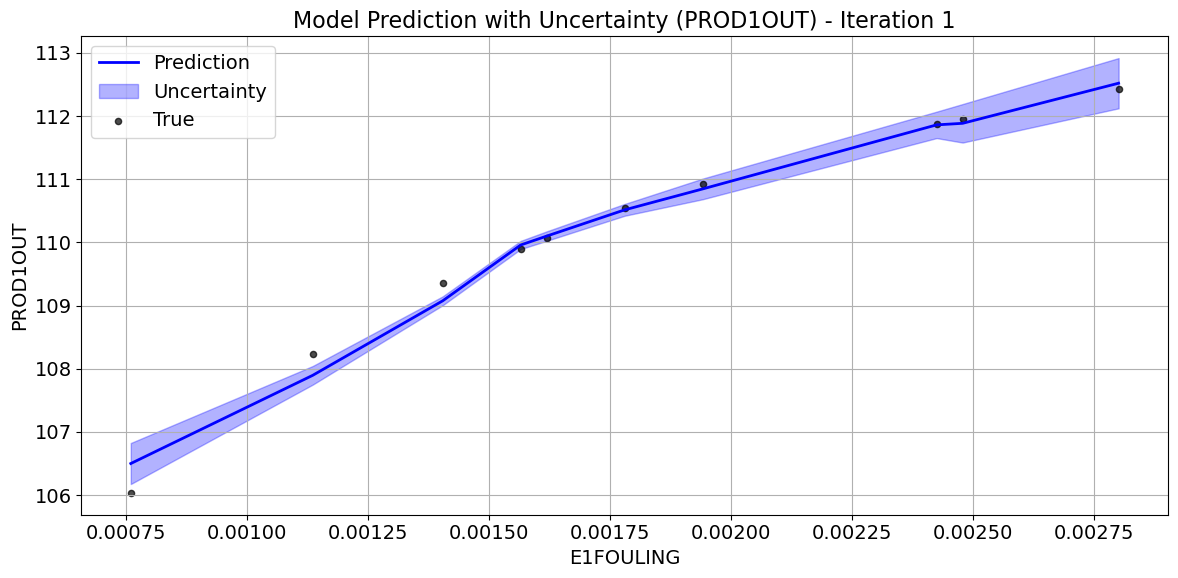


🧪 Iteration 1: Please simulate the following 20 x points:
    E1FOULING
6    0.000370
10   0.000296
11   0.000343
13   0.000420
9    0.000362
5    0.000460
12   0.000336
14   0.000652
17   0.002604
3    0.000454
18   0.002720
0    0.002588
2    0.000969
15   0.000973
8    0.000941
16   0.001964
1    0.001749
19   0.001273
4    0.001714
7    0.001359
{'E1FOULING': 0.00036952825343229294}
{'PROD1OUT': 102.21238675421591}
{'E1FOULING': 0.0002955789260900719}
{'PROD1OUT': 101.09384806655237}
{'E1FOULING': 0.0003432759978022576}
{'PROD1OUT': 101.78589578854593}
{'E1FOULING': 0.00041964499297297863}
{'PROD1OUT': 102.78675202634724}
{'E1FOULING': 0.00036246051656174953}
{'PROD1OUT': 102.05317584709644}
{'E1FOULING': 0.00045996299713544167}
{'PROD1OUT': 103.26384937620782}
{'E1FOULING': 0.0003355835022860356}
{'PROD1OUT': 101.6773704742323}
{'E1FOULING': 0.0006520387809576734}
{'PROD1OUT': 105.18083453701712}
{'E1FOULING': 0.002603993209708072}
{'PROD1OUT': 112.15308095174203}
{'E1FOULING': 0

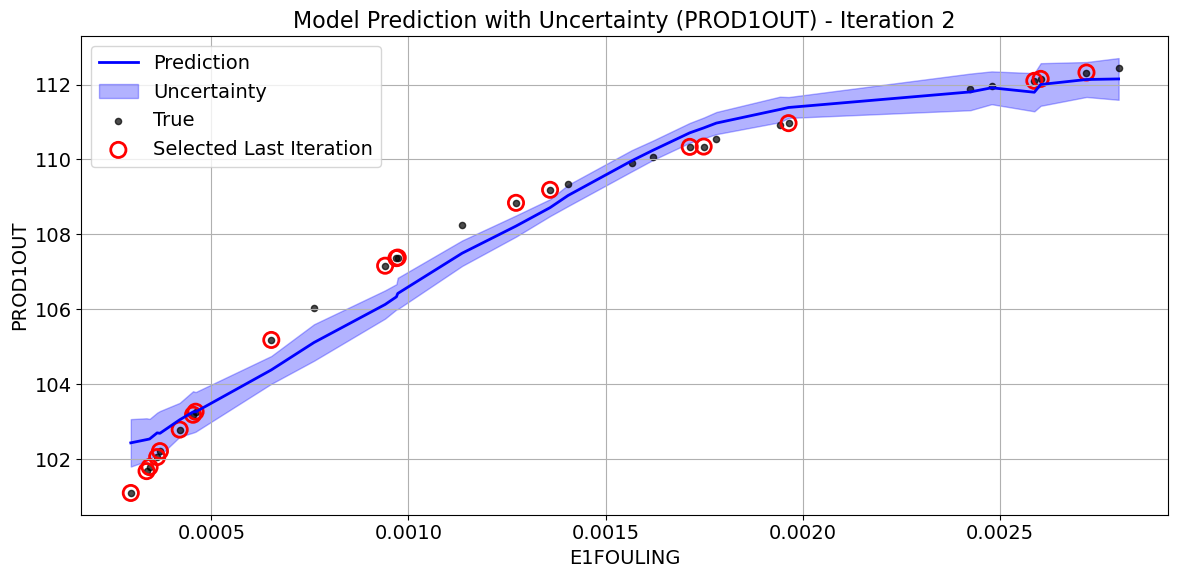


🧪 Iteration 2: Please simulate the following 20 x points:
    E1FOULING
5    0.000335
1    0.000255
2    0.000608
13   0.000361
7    0.000705
4    0.002450
0    0.000482
16   0.000464
11   0.002311
19   0.000745
12   0.001885
15   0.000540
18   0.002199
10   0.002468
14   0.000676
3    0.001194
8    0.001606
9    0.002015
17   0.001394
6    0.001395
{'E1FOULING': 0.0003347263975564464}
{'PROD1OUT': 101.65905989301024}
{'E1FOULING': 0.00025466666280106134}
{'PROD1OUT': 100.44717407585284}
{'E1FOULING': 0.0006081960036696684}
{'PROD1OUT': 104.7933296595449}
{'E1FOULING': 0.0003608962082763418}
{'PROD1OUT': 102.02767671005415}
{'E1FOULING': 0.0007046779013919898}
{'PROD1OUT': 105.61684439372766}
{'E1FOULING': 0.00245042517333084}
{'PROD1OUT': 111.91280935565396}
{'E1FOULING': 0.0004824281293184237}
{'PROD1OUT': 103.5115036915513}
{'E1FOULING': 0.00046400326754462073}
{'PROD1OUT': 103.2469694692906}
{'E1FOULING': 0.0023105185443352463}
{'PROD1OUT': 111.67311358917243}
{'E1FOULING': 0.0007

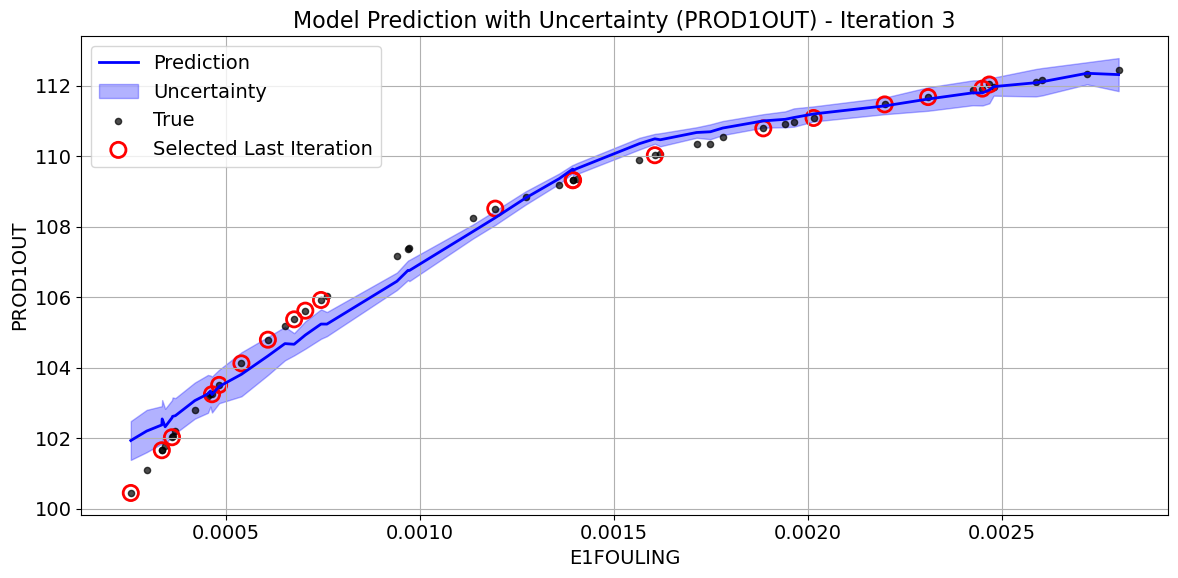


🧪 Iteration 3: Please simulate the following 20 x points:
    E1FOULING
1    0.000251
8    0.000356
19   0.000398
16   0.000378
14   0.000520
2    0.002720
9    0.002635
12   0.002838
18   0.002387
6    0.002548
13   0.000587
7    0.000880
0    0.002169
11   0.002313
5    0.002002
3    0.001384
15   0.001721
17   0.001978
4    0.001222
10   0.001382
{'E1FOULING': 0.0002510477639138015}
{'PROD1OUT': 100.37424295877338}
{'E1FOULING': 0.00035639451969671514}
{'PROD1OUT': 101.96519158921353}
{'E1FOULING': 0.0003977923289723852}
{'PROD1OUT': 102.51432545726692}
{'E1FOULING': 0.00037787783908377933}
{'PROD1OUT': 102.21536345075936}
{'E1FOULING': 0.00052034462938362}
{'PROD1OUT': 103.93053284690808}
{'E1FOULING': 0.0027201321582680654}
{'PROD1OUT': 112.323229721286}
{'E1FOULING': 0.0026347023622812224}
{'PROD1OUT': 112.18250422798786}
{'E1FOULING': 0.0028382950399352524}
{'PROD1OUT': 112.51323300095044}
{'E1FOULING': 0.002387021494652957}
{'PROD1OUT': 111.72235580526979}
{'E1FOULING': 0.0025

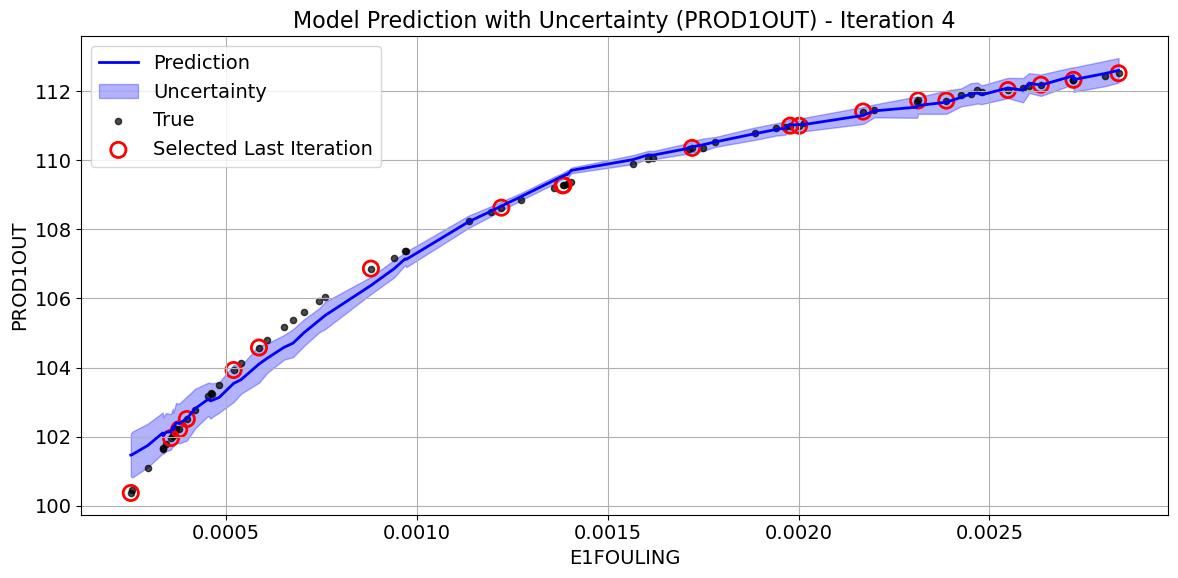


🧪 Iteration 4: Please simulate the following 20 x points:
    E1FOULING
12   0.000265
15   0.000553
18   0.000574
13   0.002830
5    0.002739
2    0.002816
14   0.002597
11   0.000748
7    0.000864
3    0.001018
19   0.000972
6    0.002006
0    0.001960
4    0.001859
1    0.001840
9    0.001253
16   0.001583
17   0.001202
10   0.001238
8    0.001311
{'E1FOULING': 0.00026463502697604346}
{'PROD1OUT': 100.59661684825454}
{'E1FOULING': 0.0005531689189622027}
{'PROD1OUT': 104.267344554653}
{'E1FOULING': 0.0005740212564621155}
{'PROD1OUT': 104.51342480674481}
{'E1FOULING': 0.002830367895147066}
{'PROD1OUT': 112.47202279218277}
{'E1FOULING': 0.0027385049716359307}
{'PROD1OUT': 112.32950127949056}
{'E1FOULING': 0.002816298590741998}
{'PROD1OUT': 112.45286258828116}
{'E1FOULING': 0.0025969472035662373}
{'PROD1OUT': 112.09037886732904}
{'E1FOULING': 0.0007478371007572767}
{'PROD1OUT': 105.93939042188038}
{'E1FOULING': 0.000864309080839771}
{'PROD1OUT': 106.76019567691179}
{'E1FOULING': 0.00101

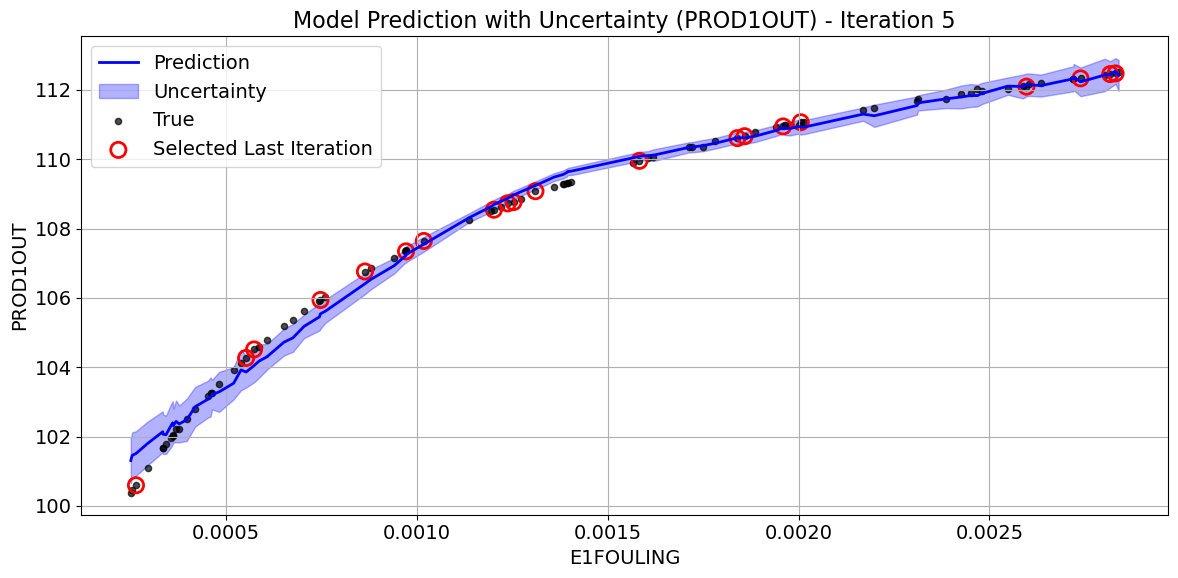


🧪 Iteration 5: Please simulate the following 20 x points:
    E1FOULING
10   0.000272
19   0.000336
15   0.000400
1    0.000440
2    0.000470
17   0.000393
16   0.000512
11   0.000661
5    0.002889
7    0.002593
8    0.000902
6    0.002458
3    0.002466
18   0.002178
13   0.002139
9    0.002154
12   0.002048
14   0.001003
0    0.001614
4    0.001465
{'E1FOULING': 0.00027169038468452625}
{'PROD1OUT': 100.71085672964841}
{'E1FOULING': 0.00033613118269222944}
{'PROD1OUT': 101.68419520710773}
{'E1FOULING': 0.0003995410867758167}
{'PROD1OUT': 102.53594717117926}
{'E1FOULING': 0.0004399041082362011}
{'PROD1OUT': 103.11709816150062}
{'E1FOULING': 0.00047007697441175424}
{'PROD1OUT': 103.38324948501969}
{'E1FOULING': 0.0003930596228675415}
{'PROD1OUT': 102.45689410997318}
{'E1FOULING': 0.0005119533541154003}
{'PROD1OUT': 103.83909172502916}
{'E1FOULING': 0.0006613976676227986}
{'PROD1OUT': 105.25536521727457}
{'E1FOULING': 0.0028891439496603766}
{'PROD1OUT': 112.54702874157431}
{'E1FOULING': 

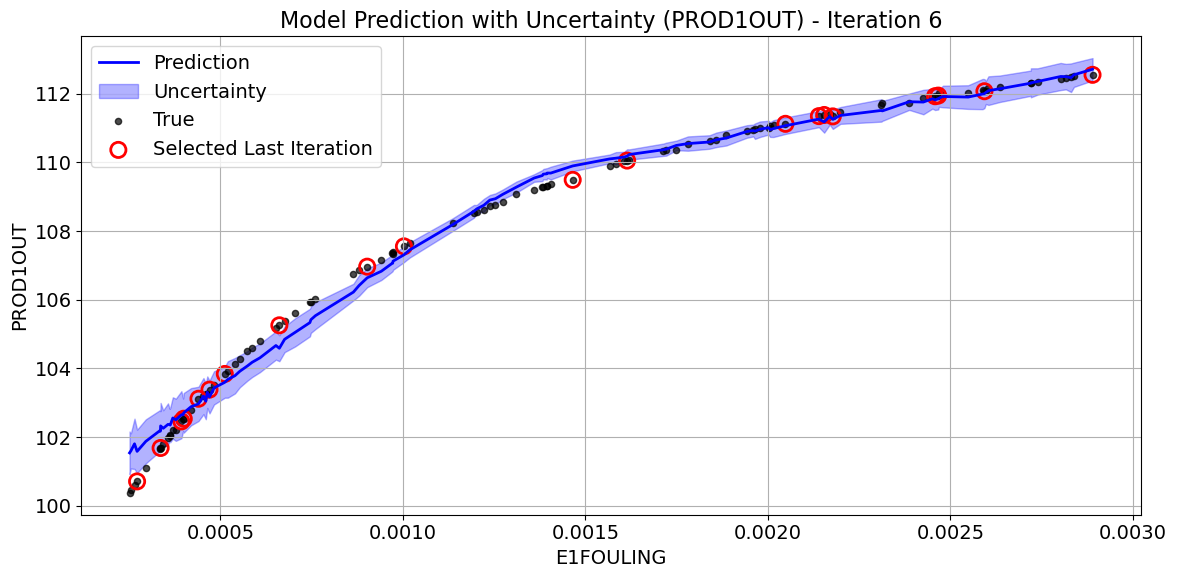


🧪 Iteration 6: Please simulate the following 20 x points:
    E1FOULING
6    0.000403
7    0.002906
0    0.002742
4    0.000532
3    0.002802
11   0.000621
5    0.000326
8    0.000446
13   0.000652
2    0.000518
16   0.002547
10   0.000959
14   0.001050
15   0.002155
19   0.001593
12   0.001636
1    0.001072
18   0.001485
17   0.001476
9    0.001321
{'E1FOULING': 0.00040293503529009527}
{'PROD1OUT': 102.57195503420633}
{'E1FOULING': 0.0029061091464858205}
{'PROD1OUT': 112.58135636815189}
{'E1FOULING': 0.002742248652990804}
{'PROD1OUT': 112.33106866189132}
{'E1FOULING': 0.0005316438185412956}
{'PROD1OUT': 104.03605512756349}
{'E1FOULING': 0.002802485424064514}
{'PROD1OUT': 112.4347924025954}
{'E1FOULING': 0.000621035274701121}
{'PROD1OUT': 104.8953497763597}
{'E1FOULING': 0.00032564126272194115}
{'PROD1OUT': 101.53308107564794}
{'E1FOULING': 0.0004464092627284893}
{'PROD1OUT': 103.10753109684771}
{'E1FOULING': 0.0006520387809576734}
{'PROD1OUT': 105.17906223885086}
{'E1FOULING': 0.0005

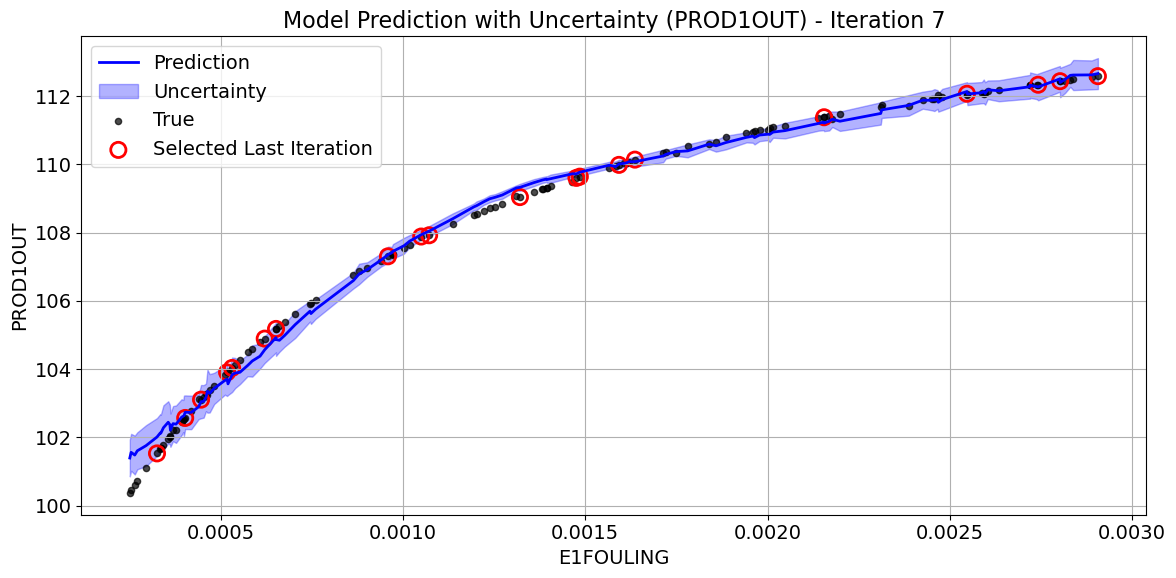


🧪 Iteration 7: Please simulate the following 20 x points:
    E1FOULING
11   0.000288
16   0.000334
5    0.000360
7    0.000513
15   0.000440
17   0.000465
3    0.002748
13   0.000523
18   0.002879
0    0.002856
9    0.000572
6    0.002565
1    0.002480
2    0.000736
10   0.000813
12   0.000927
14   0.000841
4    0.002413
8    0.002052
19   0.001238
{'E1FOULING': 0.0002878977998831275}
{'PROD1OUT': 100.96463465455821}
{'E1FOULING': 0.00033361239603352727}
{'PROD1OUT': 101.72490483894228}
{'E1FOULING': 0.00035985581985601735}
{'PROD1OUT': 102.01625833483081}
{'E1FOULING': 0.0005128986029807215}
{'PROD1OUT': 103.85311124654748}
{'E1FOULING': 0.0004399041082362011}
{'PROD1OUT': 103.0349643797827}
{'E1FOULING': 0.0004651255890642131}
{'PROD1OUT': 103.37492179146636}
{'E1FOULING': 0.002747984743700787}
{'PROD1OUT': 112.3622024383244}
{'E1FOULING': 0.0005233481989323308}
{'PROD1OUT': 103.95060138393228}
{'E1FOULING': 0.0028793231793216214}
{'PROD1OUT': 112.53460127799957}
{'E1FOULING': 0.00

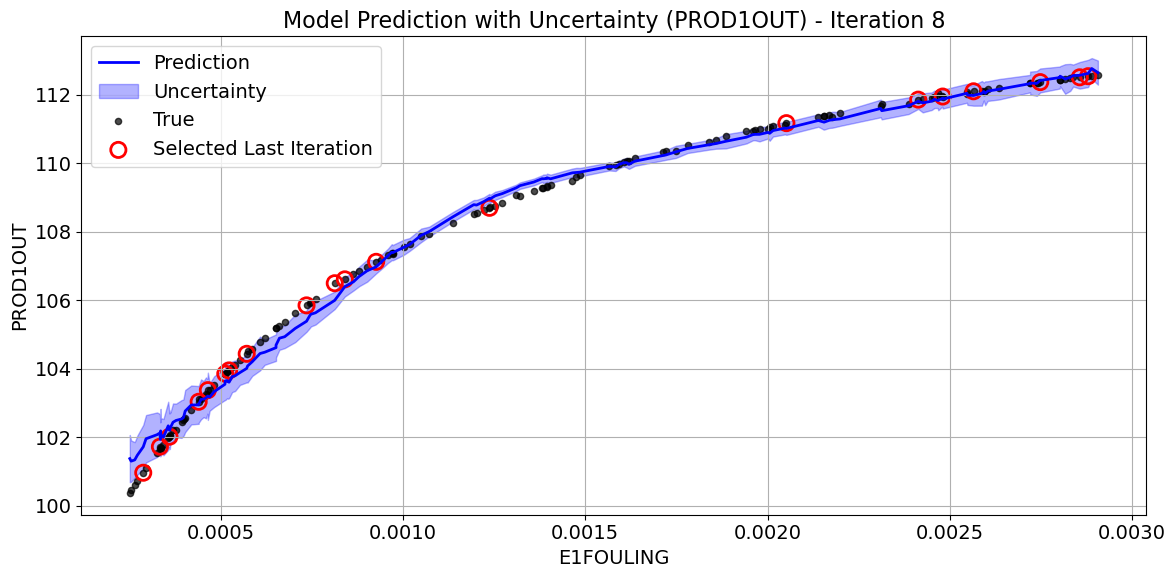


🧪 Iteration 8: Please simulate the following 20 x points:
    E1FOULING
6    0.000336
11   0.000350
12   0.000464
2    0.002796
17   0.002764
18   0.002752
4    0.002717
0    0.002768
14   0.002543
7    0.000852
1    0.000832
3    0.000869
5    0.002530
10   0.000789
9    0.002316
13   0.002141
19   0.001926
8    0.001651
15   0.001606
16   0.001304
{'E1FOULING': 0.0003355835022860356}
{'PROD1OUT': 101.67163837086002}
{'E1FOULING': 0.0003500234157707198}
{'PROD1OUT': 101.88246818714413}
{'E1FOULING': 0.00046385267129631254}
{'PROD1OUT': 103.3100604421341}
{'E1FOULING': 0.002795696764754712}
{'PROD1OUT': 112.42623318146815}
{'E1FOULING': 0.002763918381120209}
{'PROD1OUT': 112.37878265222781}
{'E1FOULING': 0.0027518858122501716}
{'PROD1OUT': 112.35950366618044}
{'E1FOULING': 0.002717413510177333}
{'PROD1OUT': 112.30350804990695}
{'E1FOULING': 0.002768183551061374}
{'PROD1OUT': 112.38561061947848}
{'E1FOULING': 0.0025433525626453093}
{'PROD1OUT': 112.00285386454584}
{'E1FOULING': 0.00085

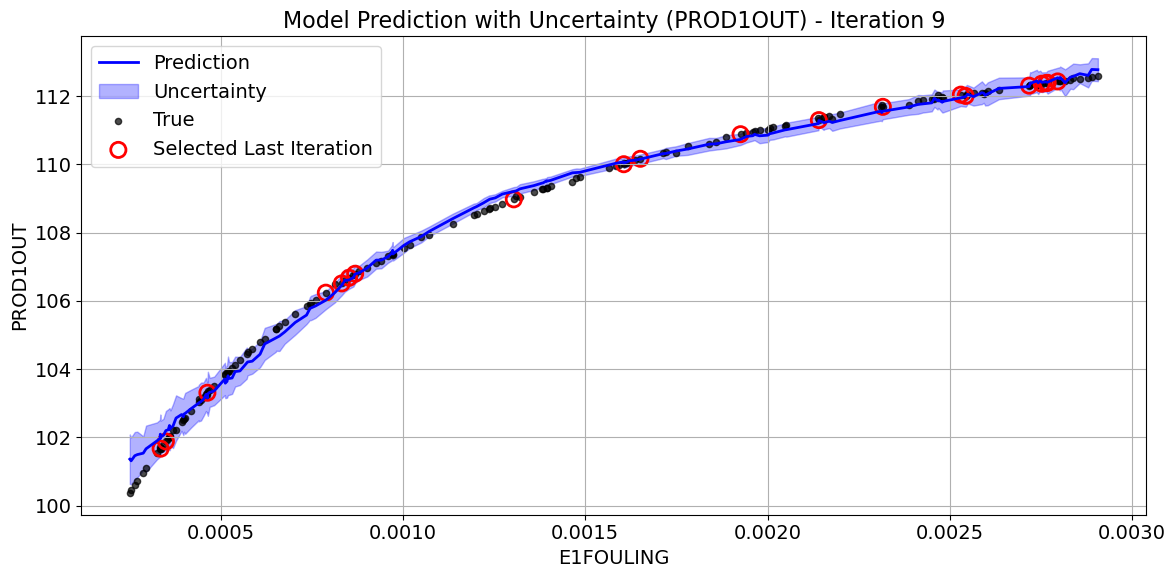


🧪 Iteration 9: Please simulate the following 20 x points:
    E1FOULING
4    0.000287
11   0.000276
15   0.000400
17   0.000449
2    0.000516
14   0.000586
13   0.002804
9    0.002629
6    0.002618
19   0.002806
18   0.002572
8    0.002335
5    0.002188
0    0.001053
16   0.001939
12   0.000942
10   0.001045
7    0.001173
3    0.001733
1    0.001297
{'E1FOULING': 0.0002868512966953154}
{'PROD1OUT': 100.94848981966288}
{'E1FOULING': 0.0002760333274858782}
{'PROD1OUT': 100.72005355837575}
{'E1FOULING': 0.0003995410867758167}
{'PROD1OUT': 102.53896176173419}
{'E1FOULING': 0.0004486749056997545}
{'PROD1OUT': 103.13561588732387}
{'E1FOULING': 0.0005159179794884375}
{'PROD1OUT': 103.8813171714529}
{'E1FOULING': 0.0005864790107205788}
{'PROD1OUT': 104.58469155120724}
{'E1FOULING': 0.002803878401693924}
{'PROD1OUT': 112.4367483491502}
{'E1FOULING': 0.0026290214469256957}
{'PROD1OUT': 112.15199230046028}
{'E1FOULING': 0.0026183974845869077}
{'PROD1OUT': 112.15199230046028}
{'E1FOULING': 0.0028

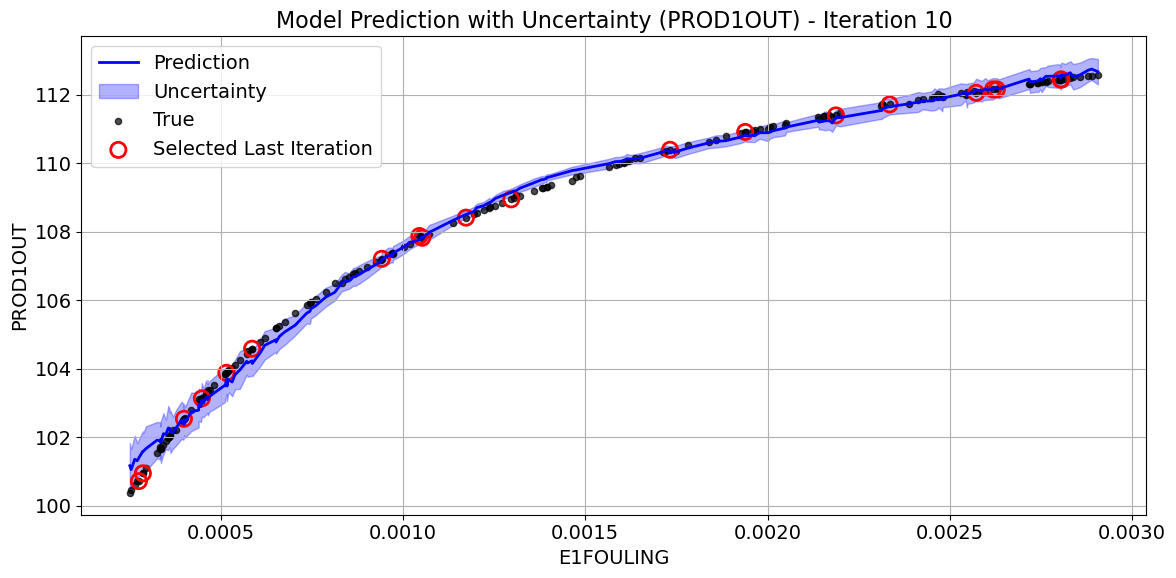


🧪 Iteration 10: Please simulate the following 20 x points:
    E1FOULING
12   0.000311
17   0.000453
1    0.000538
2    0.002875
15   0.000685
13   0.002725
19   0.000710
18   0.000780
0    0.002576
10   0.000705
14   0.002785
7    0.002757
5    0.000657
16   0.002404
4    0.002298
6    0.002131
11   0.000989
8    0.001872
3    0.001523
9    0.001371
{'E1FOULING': 0.00031082596656873497}
{'PROD1OUT': 101.3121154137458}
{'E1FOULING': 0.00045294068802900707}
{'PROD1OUT': 103.18828469691476}
{'E1FOULING': 0.0005380189191281176}
{'PROD1OUT': 104.10955660250931}
{'E1FOULING': 0.0028754466346948967}
{'PROD1OUT': 112.52988470543806}
{'E1FOULING': 0.0006851789731264325}
{'PROD1OUT': 105.44648419006592}
{'E1FOULING': 0.0027248261754301787}
{'PROD1OUT': 112.3290988276969}
{'E1FOULING': 0.0007100204947682559}
{'PROD1OUT': 105.64718268683936}
{'E1FOULING': 0.0007799259445652935}
{'PROD1OUT': 106.25206339785933}
{'E1FOULING': 0.002576368905260626}
{'PROD1OUT': 112.11171813392934}
{'E1FOULING': 0.0

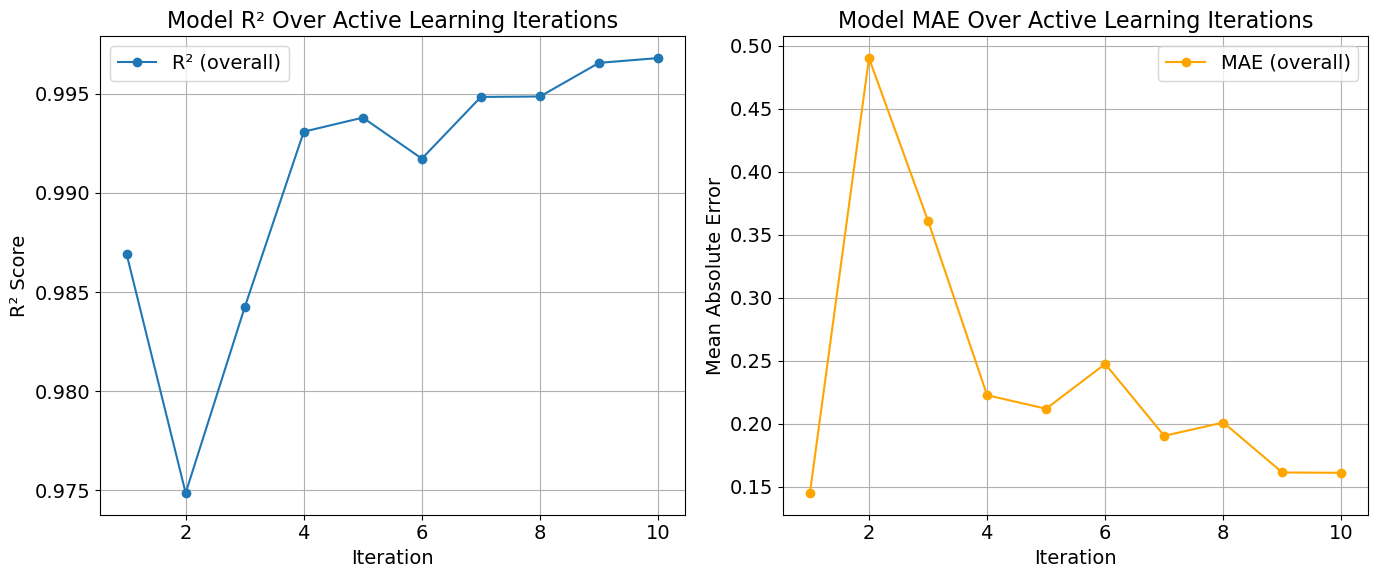

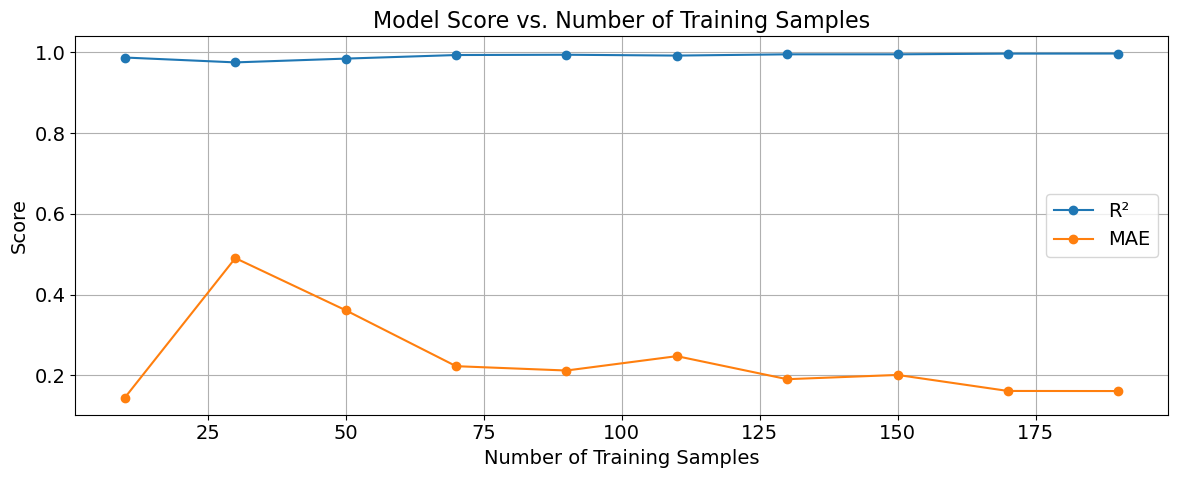

In [18]:
r2_overall = []
mae_overall = []
n_train_samples = []
# ---------------------------
# ACTIVE LEARNING LOOP
# ---------------------------
for i in range(n_iterations):
    print(f"\n--- Iteration {i+1} ---")

    # Train BNN
    model = build_bnn_model(input_dim, output_dim)
    model.fit(X_train.values, Y_train.values, epochs=200, batch_size=16, verbose=0)

    # --- PLOT CURRENT MODEL ---
    X_train_tensor = tf.convert_to_tensor(X_train.values, dtype=tf.float32)
    train_mean, train_std = predict_with_uncertainty(model, X_train_tensor, mc_iterations)

    train_mean_inv = scaler.y_scaler.inverse_transform(train_mean)
    train_std_inv = train_std * scaler.y_scaler.scale_
    Y_train_inv = scaler.y_scaler.inverse_transform(Y_train)

    # Evaluate R2 and MAE for each output
    r2_scores = []
    mae_scores = []

    print(f"📊 Performance metrics at iteration {i+1}:")

    for j, col in enumerate(y_cols):
        r2 = r2_score(Y_train_inv[:, j], train_mean_inv[:, j])
        mae = mean_absolute_error(Y_train_inv[:, j], train_mean_inv[:, j])
        
        r2_scores.append(r2)
        mae_scores.append(mae)
        
        print(f"  - {col}: R2 = {r2:.4f}, MAE = {mae:.4f}")

    # Overall metrics
    overall_r2 = np.mean(r2_scores)
    overall_mae = np.mean(mae_scores)

    # Store overall metrics (e.g., mean over targets)
    r2_overall.append(np.mean(r2_scores))
    mae_overall.append(np.mean(mae_scores))
    n_train_samples.append(len(X_train))

    print(f"✅ Overall R2 = {overall_r2:.4f}, Overall MAE = {overall_mae:.4f}")

    x_axis = train_indices
    # Use a fouling variable for x-axis (can change to any input you want)
    x_axis = pd.DataFrame(scaler.x_scaler.inverse_transform(X_train), columns=x_cols)['E1FOULING'].values

    # Sort x values for smooth line plot
    sorted_idx = np.argsort(x_axis)
    x_sorted = x_axis[sorted_idx]
    y_mean_sorted = train_mean_inv.flatten()[sorted_idx]
    y_std_sorted = train_std_inv.flatten()[sorted_idx]
    y_true_sorted = Y_train_inv.flatten()[sorted_idx]

    plt.figure(figsize=(12, 6))

    # Line plot of predictions
    plt.plot(x_sorted, y_mean_sorted, color='blue', label='Prediction', linewidth=2)

    # Shaded uncertainty region
    plt.fill_between(x_sorted,
                    y_mean_sorted - y_std_sorted,
                    y_mean_sorted + y_std_sorted,
                    color='blue', alpha=0.3, label='Uncertainty')

    # True values as scatter
    plt.scatter(x_sorted, y_true_sorted, color='black', s=20, alpha=0.7, label='True')

    # Optional: highlight newly selected points
    if i > 0:
        x_selected = x_axis[-points_per_iter:]
        y_selected = Y_train_inv[-points_per_iter:].flatten()
        plt.scatter(x_selected, y_selected,
                    facecolors='none', edgecolors='red',
                    s=120, linewidths=2, label='Selected Last Iteration')

    plt.title(f'Model Prediction with Uncertainty ({target_to_plot}) - Iteration {i+1}')
    plt.xlabel('E1FOULING')
    plt.ylabel(target_to_plot)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------------------
    # STEP 1: Generate new candidate Xs
    # --------------------------------
    # This should be your own simulator/space sampler (e.g., Latin Hypercube)
    df_candidates = generate_candidate_points(model, scaler, x_cols, n_total=3000, n_select=20, mc_iterations=50)

    X_candidate = scaler.x_scaler.transform(df_candidates[x_cols])  # shape (N, D)
    X_candidate_tensor = tf.convert_to_tensor(X_candidate, dtype=tf.float32)

    # --------------------------------
    # STEP 2: Predict uncertainty
    # --------------------------------
    mean_preds, std_preds = predict_with_uncertainty(model, X_candidate_tensor, mc_iterations)
    uncertainty_score = np.mean(std_preds, axis=1)

    # --------------------------------
    # STEP 3: Select most uncertain points
    # --------------------------------
    top_k = min(points_per_iter, len(df_candidates))
    top_k_pos = np.argsort(-uncertainty_score)[:top_k]
    selected_x_df = df_candidates.iloc[top_k_pos]

    print(f"\n🧪 Iteration {i+1}: Please simulate the following {top_k} x points:")
    print(selected_x_df[x_cols])

    # 👇 After simulation, you return the corresponding y_cols values:
    samplingresult = []
    for keys, items in selected_x_df[x_cols].iterrows():
        # run sim
        print(dict(items))
        simres = simd.predict(dict(items))
        print(simres)
        # add to list
        samplingresult.append(simres)

    df_simulated_y = pd.DataFrame(samplingresult)
    
    selected_xy_df = pd.concat([selected_x_df[x_cols].reset_index(drop=True),
                                df_simulated_y[y_cols].reset_index(drop=True)], axis=1)

    # --------------------------------
    # STEP 4: Scale and add to training
    # --------------------------------
    new_X_scaled = pd.DataFrame(scaler.x_scaler.transform(selected_xy_df[x_cols]), columns=x_cols)
    new_Y_scaled = pd.DataFrame(scaler.y_scaler.transform(selected_xy_df[y_cols]), columns=y_cols)

    X_train = pd.concat([X_train, new_X_scaled], ignore_index=True)
    Y_train = pd.concat([Y_train, new_Y_scaled], ignore_index=True)

    new_indices = selected_x_df.index.to_numpy()  # keep traceability from your candidate pool
    train_indices = np.concatenate([train_indices, new_indices])


iterations = list(range(1, len(r2_overall)+1))

plt.figure(figsize=(14, 6))

# --- R² over iterations ---
plt.subplot(1, 2, 1)
plt.plot(iterations, r2_overall, marker='o', label='R² (overall)')
plt.xlabel('Iteration')
plt.ylabel('R² Score')
plt.title('Model R² Over Active Learning Iterations')
plt.grid(True)
plt.legend()

# --- MAE over iterations ---
plt.subplot(1, 2, 2)
plt.plot(iterations, mae_overall, marker='o', color='orange', label='MAE (overall)')
plt.xlabel('Iteration')
plt.ylabel('Mean Absolute Error')
plt.title('Model MAE Over Active Learning Iterations')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Optional: plot vs. training sample size
plt.figure(figsize=(12, 5))
plt.plot(n_train_samples, r2_overall, '-o', label='R²')
plt.plot(n_train_samples, mae_overall, '-o', label='MAE')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.title('Model Score vs. Number of Training Samples')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Multi dim adaptive learning

In [17]:
# Simulation Cols mapping
cols_mapping = {'InputParams': {'FEED1MASSFLOW': 'C3', 'FEED1TEMP': 'C4','PROD1MASSFLOW': 'C5','PROD1TEMP': 'C6',
                          'E1FOULING': 'C11', 'E2FOULING': 'C15'},
               'OutputParams': {'PROD1E1IN': 'C3', 'PROD1OUT': 'C4', 'FEED1E1OUT': 'C7', 'FEED1OUT': 'C8'},
               'Outputuoms': {'PROD1E1IN': 'C', 'PROD1OUT': 'C', 'FEED1E1OUT': 'C', 'FEED1OUT': 'C'}
               }
# X , y cols sorrend a fontos az ANN-hez majd
x_cols = list(cols_mapping['InputParams'].keys())
y_cols = list(cols_mapping['OutputParams'].keys())

In [18]:
# --- Config: Target to visualize ---
target_to_plot = 'PROD1OUT'  # Choose from y_cols
target_index = y_cols.index(target_to_plot)

# --- Feature and target columns ---
#x_cols = ['FEED1MASSFLOW', 'FEED1TEMP', 'PROD1MASSFLOW', 'PROD1TEMP', 'E1FOULING', 'E2FOULING']
#y_cols = ['PROD1E1IN', 'PROD1OUT', 'FEED1E1OUT', 'FEED1OUT']


In [19]:
df_raw = pd.read_csv('../01_DataCollecting/Sim_result/Surrogate_dataset_LHS_200.csv', index_col=0, encoding='ISO-8859-1')
df_raw.reset_index(drop=True, inplace=True)

In [20]:
scaler = DS()
scaled_df = scaler.fit_transform(df_raw, x_cols, y_cols)

# Initial
X_train_t = scaled_df[x_cols]
y_train_t = scaled_df[y_cols]


# --- Active Learning Loop ---
initial_train_size = 50
points_per_iter = 10
n_iterations = 10
mc_iterations = 50

original_indices = np.arange(len(scaled_df))

# Shuffle all indices
np.random.seed(42)  # for reproducibility
shuffled_indices = np.random.permutation(len(scaled_df))

# Select 50 for initial training, rest for the pool
train_indices = shuffled_indices[:initial_train_size]
pool_indices = shuffled_indices[initial_train_size:]

X_train = X_train_t.loc[train_indices]
Y_train = y_train_t.loc[train_indices]

# ezt kellene szimulációval kiszedni majd
X_pool = X_train_t.loc[pool_indices]
Y_pool = y_train_t.loc[pool_indices]

input_dim = X_train.shape[1]
output_dim = Y_train.shape[1]

In [21]:
train_data = pd.concat([scaler.inverse_transform_x(X_train[x_cols]), scaler.inverse_transform_y(Y_train[y_cols])], axis=1)

In [22]:
train_data

,FEED1MASSFLOW,FEED1TEMP,PROD1MASSFLOW,PROD1TEMP,E1FOULING,E2FOULING,PROD1E1IN,PROD1OUT,FEED1E1OUT,FEED1OUT
0,20250.0,33.3125,55300.0,132.1875,0.001949,0.002271,128.665907,124.277713,45.250853,54.937189
1,19750.0,18.8125,40500.0,126.7875,0.002580,0.001667,120.206908,115.293797,28.806615,42.325294
2,11850.0,21.3125,40900.0,110.8125,0.002594,0.001277,105.174697,101.408894,34.238131,53.612107
3,22350.0,11.6875,33900.0,98.4375,0.002808,0.001264,90.996119,86.851856,17.981827,29.212383
4,16250.0,21.6875,37900.0,94.3875,0.002835,0.002298,90.829663,87.639409,29.079679,37.312847
5,26750.0,27.6875,31100.0,120.2625,0.000270,0.000861,110.742473,94.166244,46.850376,57.918321
6,14350.0,16.4375,39500.0,128.1375,0.001801,0.001439,121.272390,114.786076,34.306571,53.258389
7,18050.0,11.4375,51100.0,91.0125,0.001170,0.002365,88.329010,83.200466,25.952241,33.475422
8,22950.0,14.8125,36900.0,110.5875,0.001304,0.002902,106.588059,98.710507,27.394466,33.798814
9,28550.0,27.5625,47500.0,94.8375,0.001694,0.000942,89.456681,85.819474,33.566140,42.446454


In [23]:
# init driver
simd = SM.simulation_driver(hy_filename, cols_mapping, x_cols, y_cols, resultindict = True)
simd.load_model()

In [24]:
def generate_candidate_points(model, scaler, x_cols, n_total=3000, n_select=50, mc_iterations=50):
    from scipy.stats import qmc
    # Step 1: Sample candidate space
    bounds = {
        'FEED1MASSFLOW': (10000, 30000),
        'FEED1TEMP': (10, 35),
        'PROD1MASSFLOW': (20000, 60000),
        'PROD1TEMP': (90, 135),
        'E1FOULING': (0.00025, 0.002936),
        'E2FOULING': (0.00025, 0.002936)
    }

    variables = x_cols
    lower = np.array([bounds[v][0] for v in variables])
    upper = np.array([bounds[v][1] for v in variables])

    sampler = qmc.LatinHypercube(d=len(variables), seed=42)
    sample = sampler.random(n=n_total)
    candidate_points = qmc.scale(sample, lower, upper)
    df_candidates = pd.DataFrame(candidate_points, columns=variables)

    # Step 2: Scale and predict with BNN
    scaled_candidates = scaler.x_scaler.transform(df_candidates[variables])
    X_tensor = tf.convert_to_tensor(scaled_candidates, dtype=tf.float32)
    mean, std = predict_with_uncertainty(model, X_tensor, mc_iterations)

    # Step 3: Sample from high-uncertainty regions
    uncertainty_score = np.mean(std, axis=1)
    prob = uncertainty_score / np.sum(uncertainty_score)
    #selected_indices = np.argsort(-uncertainty_score)[:n_select]
    selected_indices = np.random.choice(len(df_candidates), size=n_select, replace=False, p=prob)

    return df_candidates.iloc[selected_indices].reset_index(drop=True)



--- Iteration 1 ---
📊 Performance metrics at iteration 1:
  - PROD1E1IN: R2 = 0.9938, MAE = 0.7988
  - PROD1OUT: R2 = 0.9944, MAE = 0.6932
  - FEED1E1OUT: R2 = 0.9845, MAE = 0.9418
  - FEED1OUT: R2 = 0.9822, MAE = 1.3425
✅ Overall R2 = 0.9887, Overall MAE = 0.9441


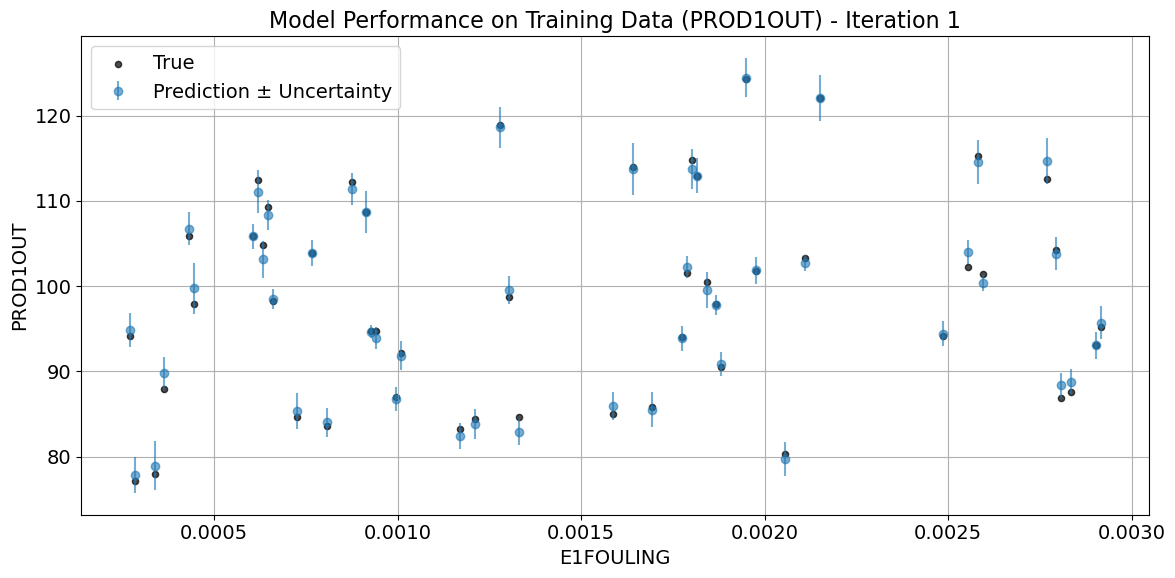


🧪 Iteration 1: Please simulate the following 10 x points:
   FEED1MASSFLOW  FEED1TEMP  PROD1MASSFLOW   PROD1TEMP  E1FOULING  E2FOULING
2   29295.191069  20.992026   27330.951618  131.880745   0.000423   0.002351
3   23384.854428  17.594221   24277.134064   97.725575   0.002112   0.001006
5   16457.817223  25.418327   26295.063643   90.367204   0.002589   0.001347
0   15417.034428  15.470089   27739.559459   94.969679   0.002485   0.002672
7   22080.272196  11.792603   31516.224866   95.087746   0.001619   0.002200
1   19075.649552  24.623963   36809.394789  107.701300   0.001108   0.000264
8   22261.995627  13.349942   33984.219179  116.733748   0.001825   0.000859
9   20180.555734  17.847405   56631.191216  111.390161   0.001561   0.002769
6   29954.062815  23.107558   48182.834420   97.217013   0.001324   0.002679
4   12965.447312  17.632764   46924.587292  102.164221   0.001099   0.002575

--- Iteration 2 ---
📊 Performance metrics at iteration 2:
  - PROD1E1IN: R2 = 0.9964, MAE = 0

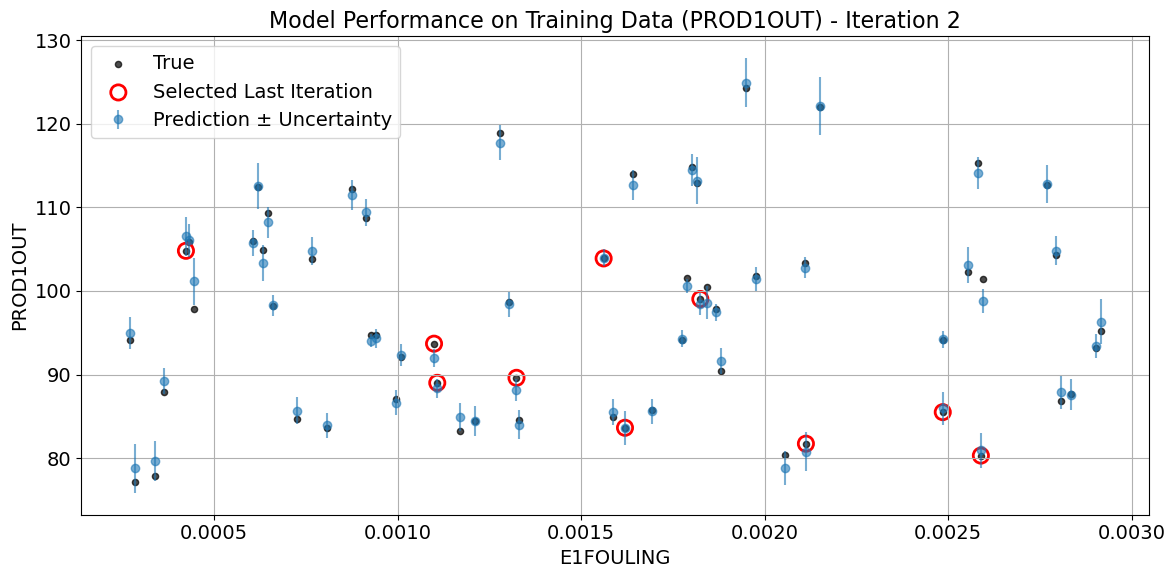


🧪 Iteration 2: Please simulate the following 10 x points:
   FEED1MASSFLOW  FEED1TEMP  PROD1MASSFLOW   PROD1TEMP  E1FOULING  E2FOULING
6   21546.254097  12.049787   27365.338415  130.198927   0.000770   0.002310
7   28772.297056  15.776047   31142.890041  112.191578   0.000832   0.002136
3   14752.032096  33.841184   29440.676086  126.773957   0.001706   0.001853
8   29466.717882  20.885184   41117.025169   95.990653   0.002738   0.001959
9   27870.477217  19.130473   50453.526142   96.814631   0.002543   0.001735
1   23692.451938  26.883041   45057.052608   93.302284   0.001403   0.001262
4   25641.229967  22.877437   26583.277054  122.063006   0.002076   0.002353
5   16907.866734  15.094244   38638.233981  101.383287   0.002506   0.001041
0   18448.827603  33.455230   33193.162064  101.427181   0.001998   0.001287
2   10225.331958  27.779519   34388.670402  113.957986   0.002745   0.001795

--- Iteration 3 ---
📊 Performance metrics at iteration 3:
  - PROD1E1IN: R2 = 0.9950, MAE = 0

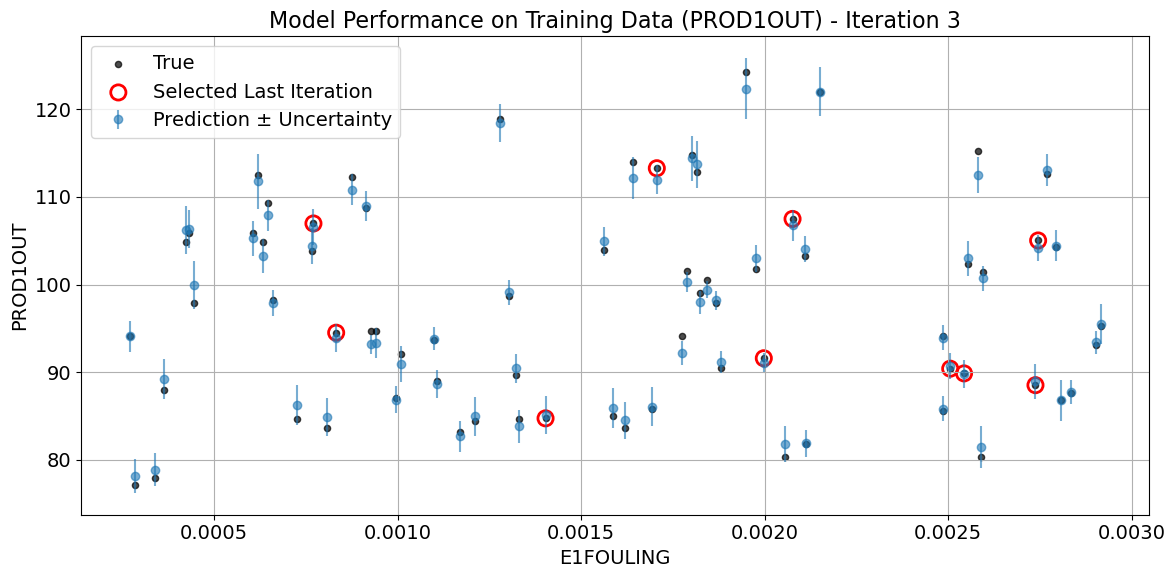


🧪 Iteration 3: Please simulate the following 10 x points:
   FEED1MASSFLOW  FEED1TEMP  PROD1MASSFLOW   PROD1TEMP  E1FOULING  E2FOULING
1   20543.819857  14.699168   42421.320982  130.815243   0.000445   0.002831
5   17216.369785  11.996551   20042.097807  100.820365   0.000597   0.000318
6   11084.441001  10.606925   24889.859768   98.836318   0.002191   0.002891
7   23878.000558  25.152861   52309.143756  130.947535   0.002848   0.001750
3   19892.065276  15.807490   53018.154596  129.369103   0.000906   0.000508
4   24586.109586  19.213414   59316.564172  121.332451   0.002512   0.000826
8   19391.983965  31.753838   51993.581661   99.426426   0.000826   0.001695
9   10094.368466  20.893040   30020.938279  120.195499   0.002008   0.001459
2   16835.730833  20.845449   52825.013069   95.349109   0.001392   0.001782
0   13274.806691  33.640545   28366.185760  115.687287   0.001866   0.001967

--- Iteration 4 ---
📊 Performance metrics at iteration 4:
  - PROD1E1IN: R2 = 0.9940, MAE = 0

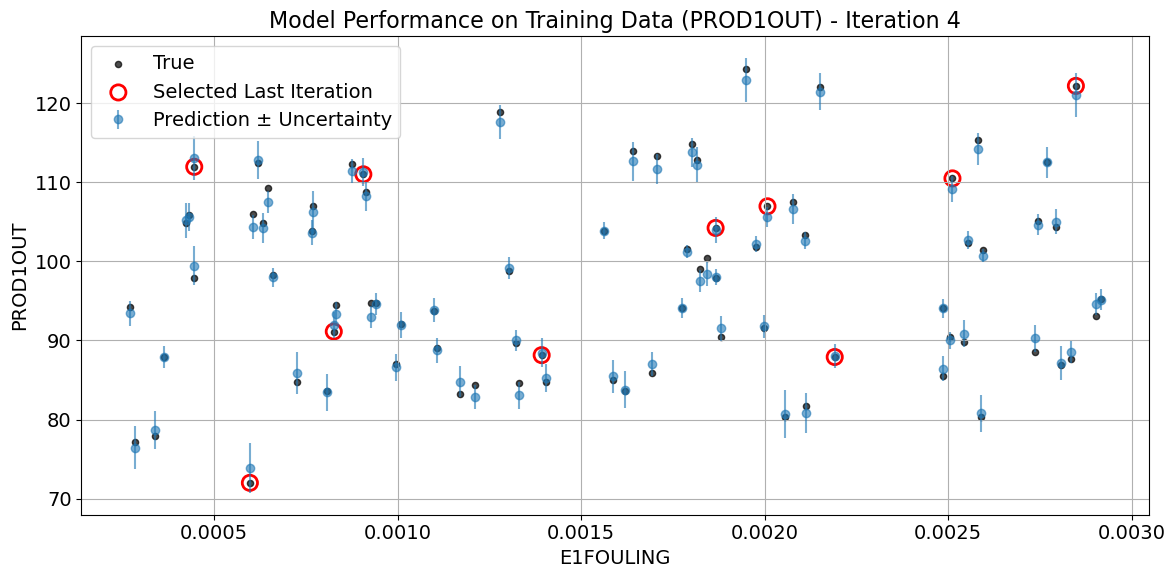


🧪 Iteration 4: Please simulate the following 10 x points:
   FEED1MASSFLOW  FEED1TEMP  PROD1MASSFLOW   PROD1TEMP  E1FOULING  E2FOULING
5   22953.523975  14.636195   26792.152491  123.839749   0.002858   0.000885
4   22726.815502  33.165771   30256.054602  131.729826   0.000367   0.002121
9   26338.502070  28.242944   23954.677396  107.909473   0.000311   0.001124
0   11533.017517  17.947612   36371.469499  126.683384   0.001724   0.001987
2   17633.336816  17.780566   23166.930371  123.243228   0.000737   0.002874
8   29273.733449  26.844771   53366.395264   92.703029   0.002080   0.001620
1   19842.394069  14.080358   24190.599392  122.740658   0.001525   0.001640
6   12586.770517  17.138861   31698.101128  119.338339   0.000910   0.001453
3   22937.845812  23.014277   56064.852967  100.446760   0.001169   0.000950
7   22096.058667  29.354698   26969.996179  120.302889   0.002225   0.000367

--- Iteration 5 ---
📊 Performance metrics at iteration 5:
  - PROD1E1IN: R2 = 0.9942, MAE = 0

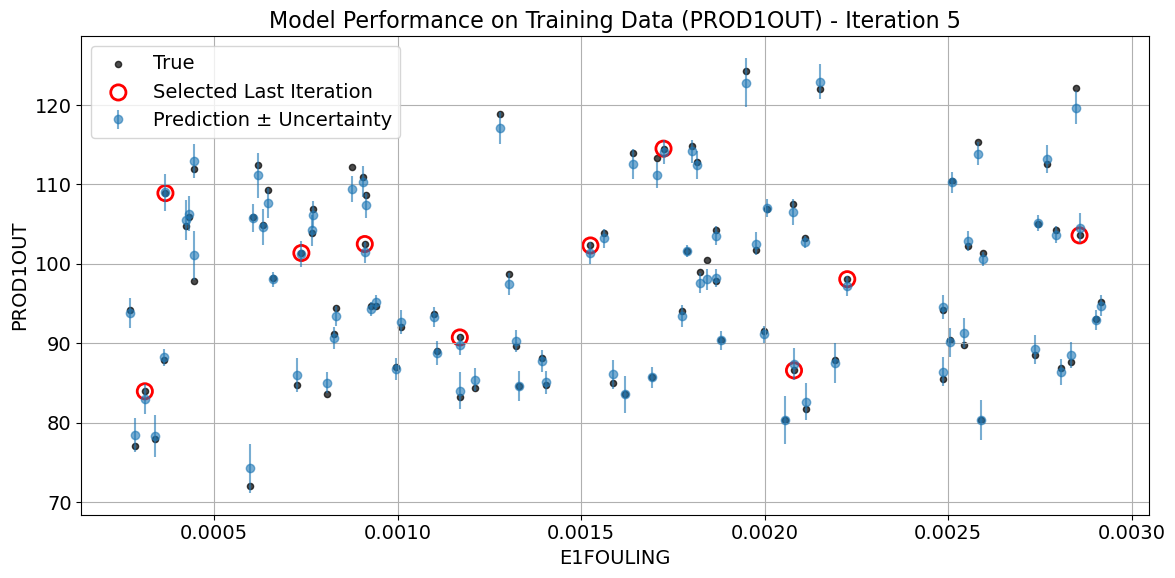


🧪 Iteration 5: Please simulate the following 10 x points:
   FEED1MASSFLOW  FEED1TEMP  PROD1MASSFLOW   PROD1TEMP  E1FOULING  E2FOULING
6   10876.273621  11.231373   41652.628156  124.730760   0.001628   0.002890
7   25386.713756  19.200525   47687.597672   92.549292   0.002773   0.000986
2   29346.151851  19.835892   31722.202861   96.522617   0.000871   0.000706
0   24306.058270  12.648339   31170.030099  124.948334   0.002642   0.000330
9   23863.755550  31.041710   37753.516258  125.032831   0.001346   0.002402
4   21985.265566  25.311197   27176.667705  103.424110   0.000505   0.000713
5   20812.941977  19.953122   36937.853095  126.552814   0.001079   0.001919
3   10159.557639  29.449029   47111.783173  108.140895   0.002874   0.001926
1   15985.018976  24.237021   39249.223963  121.174066   0.002662   0.000747
8   20741.292994  16.716100   56208.877881  109.961714   0.002228   0.001285

--- Iteration 6 ---
📊 Performance metrics at iteration 6:
  - PROD1E1IN: R2 = 0.9953, MAE = 0

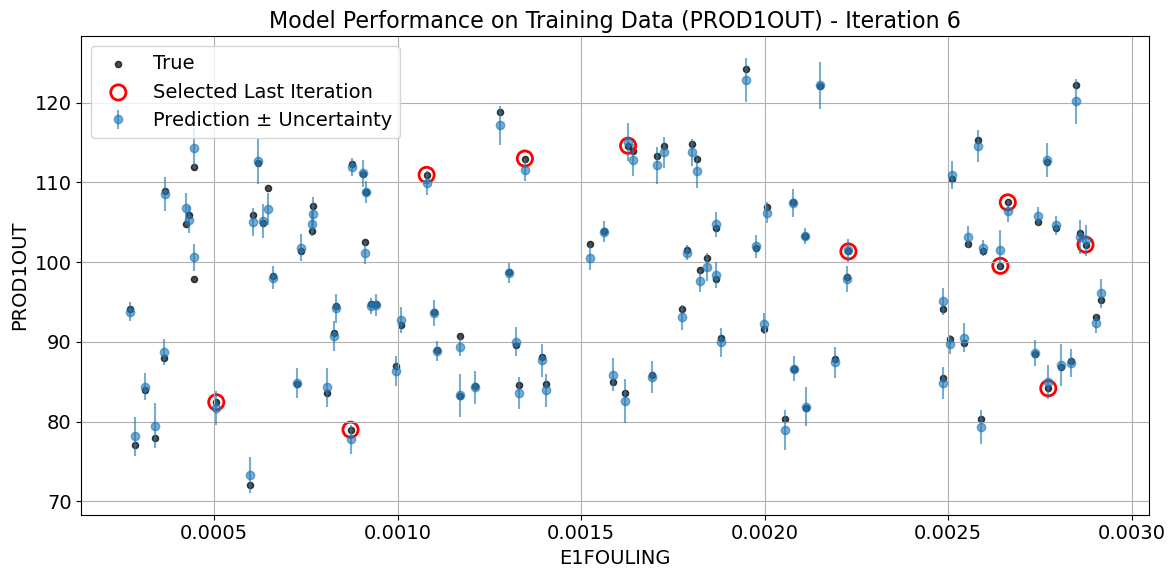


🧪 Iteration 6: Please simulate the following 10 x points:
   FEED1MASSFLOW  FEED1TEMP  PROD1MASSFLOW   PROD1TEMP  E1FOULING  E2FOULING
3   11147.824721  32.842532   27424.796679  124.851689   0.000700   0.001291
2   12724.110394  34.300514   38888.485943  130.788649   0.002192   0.000961
0   10364.548518  28.382465   22207.801973   99.328142   0.001609   0.000713
1   25380.343562  10.365205   46809.659628  103.619188   0.001878   0.002328
4   19084.928641  24.573721   37930.048637   93.467369   0.000598   0.001318
6   13453.181920  14.007583   28897.035209  102.098072   0.000854   0.000605
7   15024.131763  31.138072   21575.799402  106.150187   0.002023   0.000801
9   20443.416384  31.401489   24111.422788  104.431214   0.001042   0.001030
5   18666.173727  17.737761   35063.329984  127.126709   0.001436   0.001408
8   21509.707397  30.834790   27457.926521   98.028050   0.001427   0.001723

--- Iteration 7 ---
📊 Performance metrics at iteration 7:
  - PROD1E1IN: R2 = 0.9943, MAE = 0

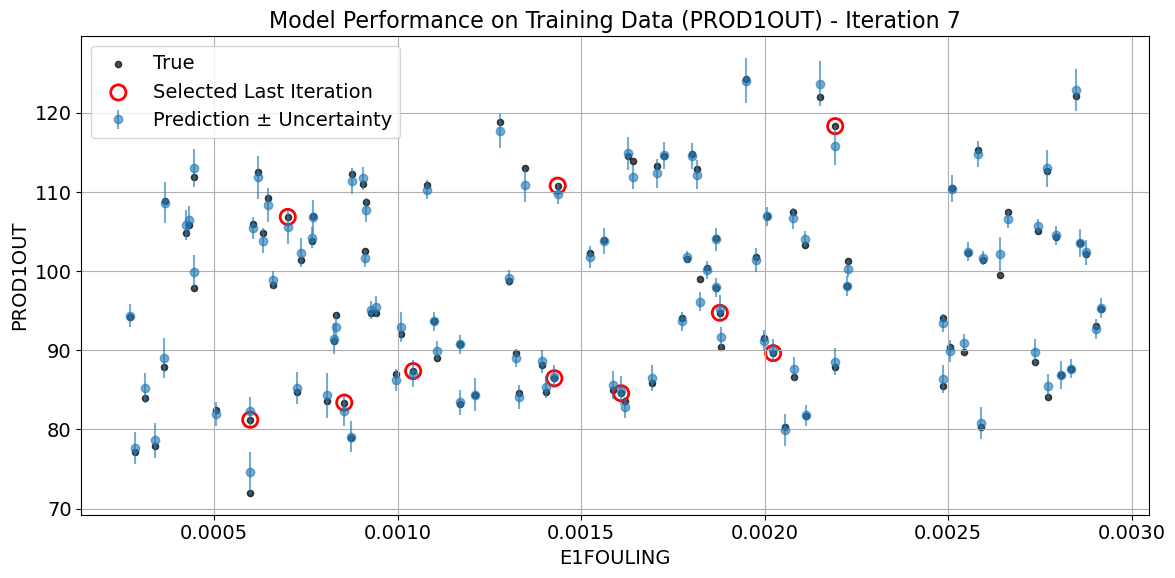


🧪 Iteration 7: Please simulate the following 10 x points:
   FEED1MASSFLOW  FEED1TEMP  PROD1MASSFLOW   PROD1TEMP  E1FOULING  E2FOULING
4   12842.359922  30.877213   46244.359650  133.435018   0.001254   0.001075
0   27130.470544  10.096052   48759.076307  100.812776   0.002332   0.000827
7   28021.485977  11.546623   21510.349263  109.918622   0.001701   0.001631
2   25961.713060  29.782211   28848.350467  129.232267   0.000622   0.001707
6   25116.150729  15.966805   59678.738081   91.611782   0.001533   0.001265
1   21749.565679  19.820431   34769.991882  126.803208   0.000348   0.001889
8   26271.846570  33.095452   20685.105511  100.627018   0.001176   0.001104
5   18396.108067  11.620984   37439.271109  104.032503   0.002070   0.002276
3   21317.437956  15.267765   32432.840001  107.645170   0.000667   0.002264
9   29081.194391  26.665191   59141.873686  102.698984   0.001365   0.001921

--- Iteration 8 ---
📊 Performance metrics at iteration 8:
  - PROD1E1IN: R2 = 0.9957, MAE = 0

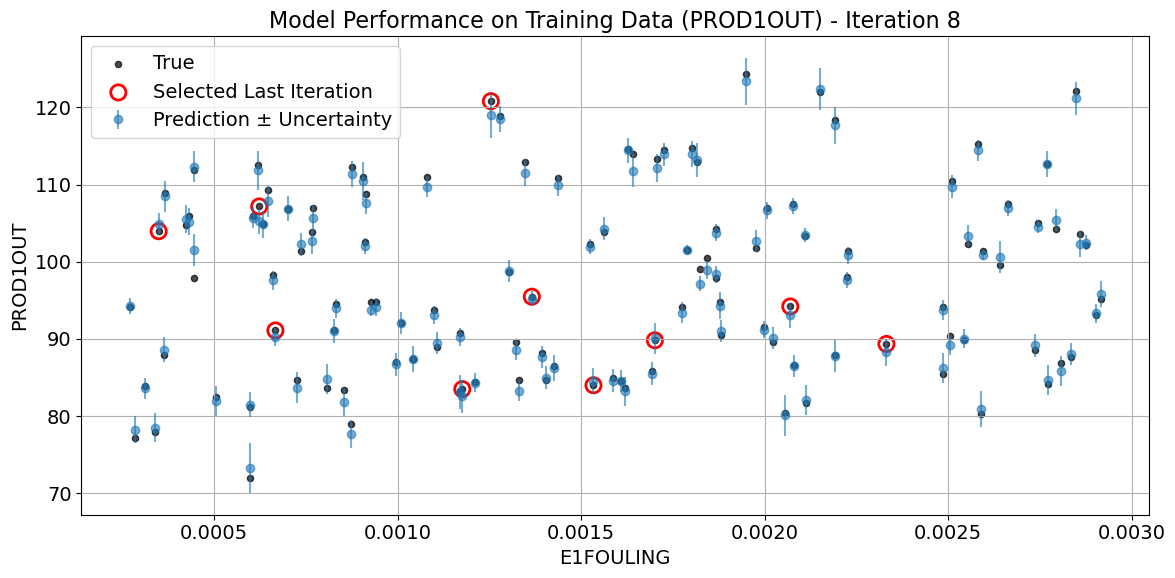


🧪 Iteration 8: Please simulate the following 10 x points:
   FEED1MASSFLOW  FEED1TEMP  PROD1MASSFLOW   PROD1TEMP  E1FOULING  E2FOULING
6   29404.790210  11.724761   59519.460492  129.158562   0.001295   0.001642
7   27031.997283  30.374107   28375.662979  131.378096   0.001646   0.002123
0   16931.559794  26.514382   34969.936955  101.877974   0.000608   0.000728
9   14734.175608  17.872950   29860.147146  122.384554   0.001777   0.000350
5   10587.419849  24.842278   24964.530989  125.487039   0.002018   0.000674
2   15358.603781  17.289786   33429.611486  100.090711   0.002590   0.001529
3   17083.258198  23.884903   59291.634311   95.608131   0.001988   0.001153
8   10667.125955  22.404404   36436.439973  111.540185   0.002364   0.001604
1   24013.336546  29.263758   38423.407959  103.885989   0.002774   0.000746
4   16308.094604  20.599239   50522.424815  114.341820   0.000984   0.001585

--- Iteration 9 ---
📊 Performance metrics at iteration 9:
  - PROD1E1IN: R2 = 0.9952, MAE = 0

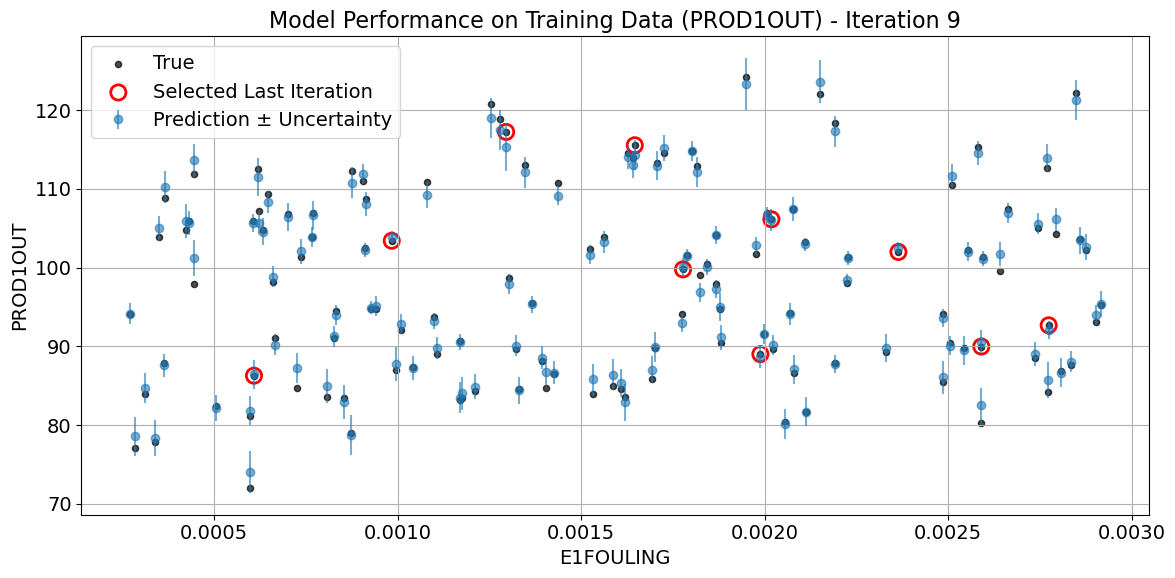


🧪 Iteration 9: Please simulate the following 10 x points:
   FEED1MASSFLOW  FEED1TEMP  PROD1MASSFLOW   PROD1TEMP  E1FOULING  E2FOULING
5   15406.473337  13.714660   59438.093042  131.658348   0.002809   0.001630
8   20281.637293  31.554735   22663.098434   93.747913   0.001336   0.002921
7   11483.055076  24.990593   27764.148040  124.890841   0.002905   0.002494
0   26716.158105  20.953602   52378.044244   92.858391   0.000797   0.001887
1   25347.007705  27.680723   21401.820883  125.268113   0.001061   0.002749
9   17428.025453  11.528044   33140.967994  111.809140   0.000728   0.001789
3   13694.085358  15.422044   49455.470489  112.911833   0.002491   0.002286
2   10767.473541  23.755528   25764.279011  103.923652   0.001837   0.002357
4   11538.395047  30.573744   21382.450231  111.564031   0.002514   0.001414
6   26664.419868  21.248779   34756.177431  123.536412   0.000751   0.000814

--- Iteration 10 ---
📊 Performance metrics at iteration 10:
  - PROD1E1IN: R2 = 0.9961, MAE =

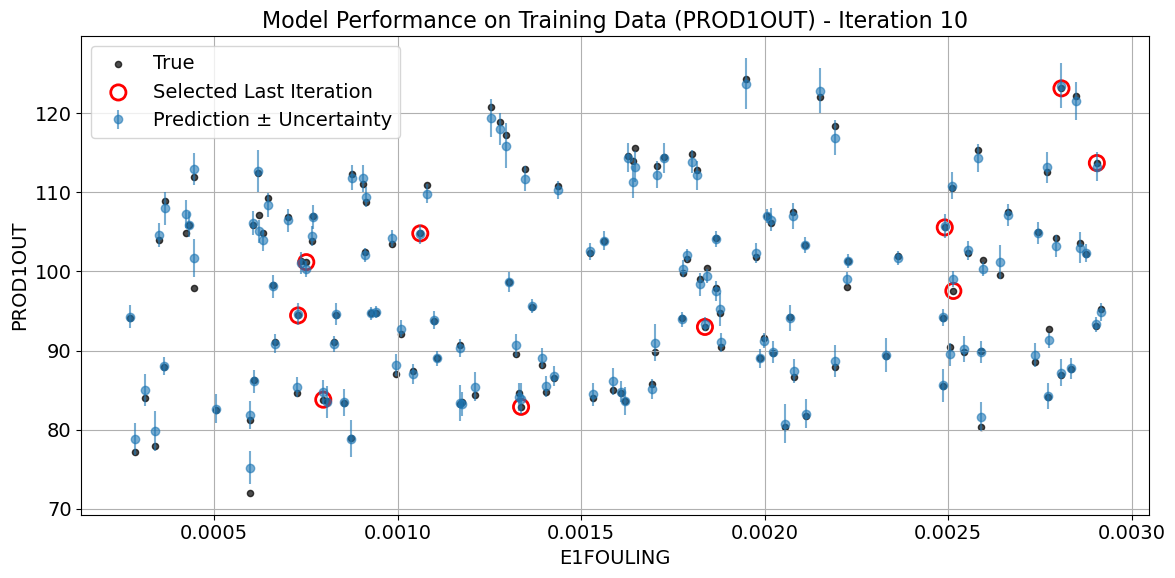


🧪 Iteration 10: Please simulate the following 10 x points:
   FEED1MASSFLOW  FEED1TEMP  PROD1MASSFLOW   PROD1TEMP  E1FOULING  E2FOULING
1   15278.626041  32.172175   54924.956920  134.803501   0.002375   0.000452
2   10072.964031  30.365211   43359.288241  127.041133   0.002242   0.002192
9   11084.441001  10.606925   24889.859768   98.836318   0.002191   0.002891
4   25742.306201  23.317207   48251.395329   90.983237   0.002770   0.002112
0   13167.428360  29.155518   35703.272882  101.611551   0.000571   0.001140
3   25576.465039  20.531038   38578.279577   95.484409   0.002437   0.002504
7   29521.062945  20.246022   30311.077758  129.346742   0.001803   0.002360
5   21102.652741  26.100198   51512.727959   97.254782   0.002511   0.001001
6   14401.863014  21.139896   39101.536536  110.130483   0.001029   0.002660
8   16757.454164  20.135363   25325.635480  117.304205   0.002427   0.001307


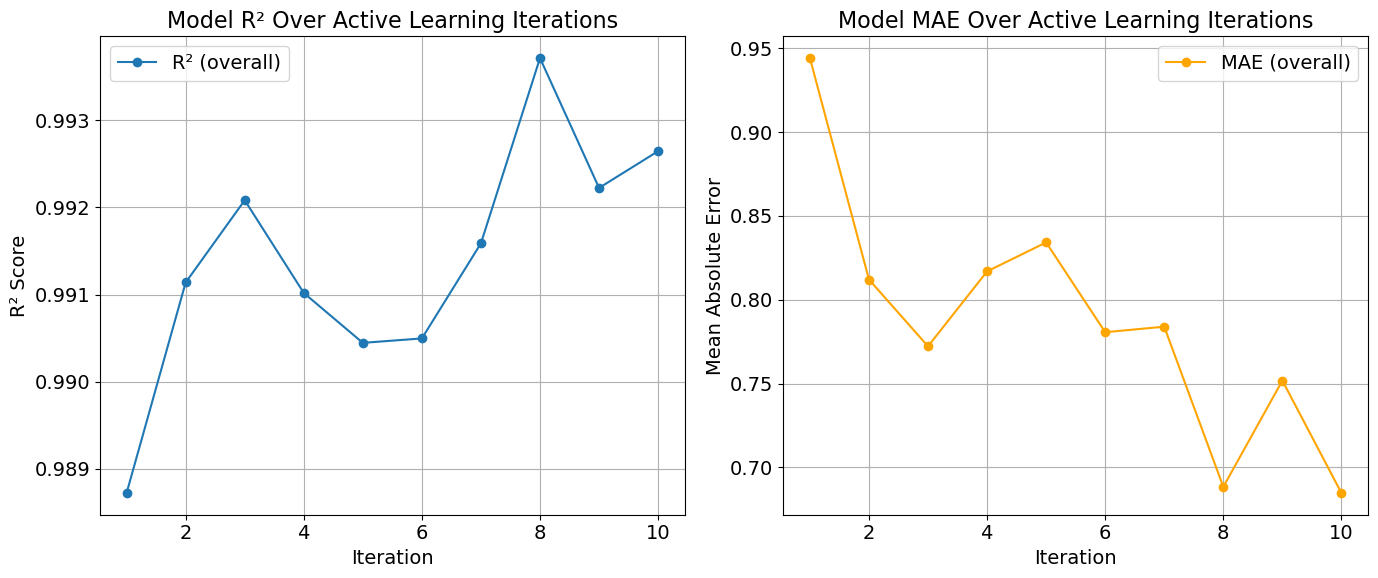

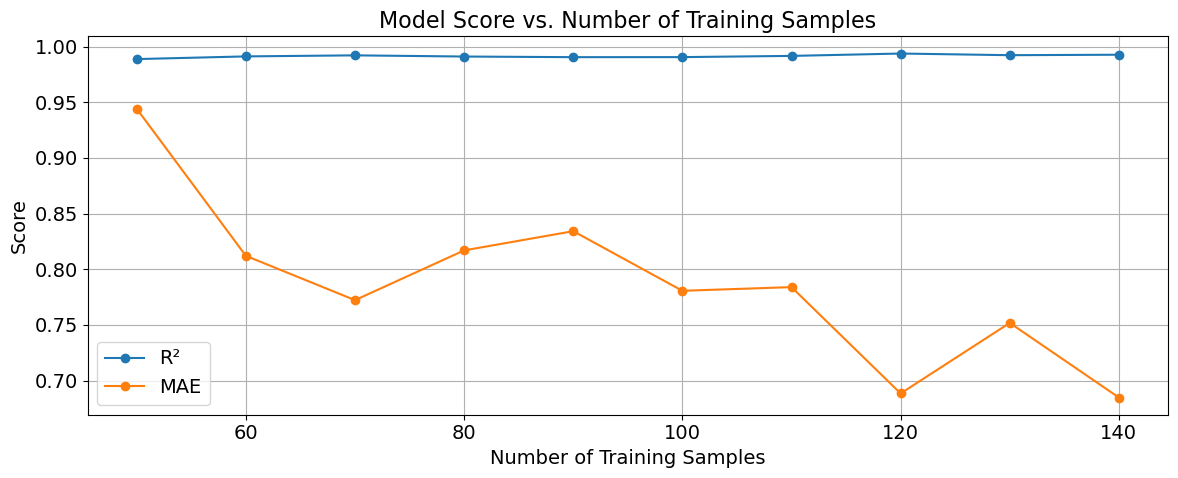

In [25]:
r2_overall = []
mae_overall = []
n_train_samples = []
# ---------------------------
# ACTIVE LEARNING LOOP
# ---------------------------
for i in range(n_iterations):
    print(f"\n--- Iteration {i+1} ---")

    # Train BNN
    model = build_bnn_model(input_dim, output_dim)
    model.fit(X_train.values, Y_train.values, epochs=200, batch_size=16, verbose=0)

    # --- PLOT CURRENT MODEL ---
    X_train_tensor = tf.convert_to_tensor(X_train.values, dtype=tf.float32)
    train_mean, train_std = predict_with_uncertainty(model, X_train_tensor, mc_iterations)

    train_mean_inv = scaler.y_scaler.inverse_transform(train_mean)
    train_std_inv = train_std * scaler.y_scaler.scale_
    Y_train_inv = scaler.y_scaler.inverse_transform(Y_train)

    # Evaluate R2 and MAE for each output
    r2_scores = []
    mae_scores = []

    print(f"📊 Performance metrics at iteration {i+1}:")

    for j, col in enumerate(y_cols):
        r2 = r2_score(Y_train_inv[:, j], train_mean_inv[:, j])
        mae = mean_absolute_error(Y_train_inv[:, j], train_mean_inv[:, j])
        
        r2_scores.append(r2)
        mae_scores.append(mae)
        
        print(f"  - {col}: R2 = {r2:.4f}, MAE = {mae:.4f}")

    # Overall metrics
    overall_r2 = np.mean(r2_scores)
    overall_mae = np.mean(mae_scores)

    # Store overall metrics (e.g., mean over targets)
    r2_overall.append(np.mean(r2_scores))
    mae_overall.append(np.mean(mae_scores))
    n_train_samples.append(len(X_train))

    print(f"✅ Overall R2 = {overall_r2:.4f}, Overall MAE = {overall_mae:.4f}")

    x_axis = train_indices
    # Use a fouling variable for x-axis (can change to any input you want)
    x_axis = pd.DataFrame(scaler.x_scaler.inverse_transform(X_train), columns=x_cols)['E1FOULING'].values

    plt.figure(figsize=(12, 6))
    plt.errorbar(x_axis, train_mean_inv[:, target_index],
                yerr=train_std_inv[:, target_index],
                fmt='o', alpha=0.6, label='Prediction ± Uncertainty')

    plt.scatter(x_axis, Y_train_inv[:, target_index],
                color='black', s=20, alpha=0.7, label='True')

    # Optional: highlight newly selected points
    if i > 0:
        # Get the corresponding x_axis values of just-added points
        x_selected = x_axis[-points_per_iter:]
        y_selected = Y_train_inv[-points_per_iter:, target_index]

        plt.scatter(x_selected, y_selected,
                    facecolors='none', edgecolors='red',
                    s=120, linewidths=2, label='Selected Last Iteration')

    plt.title(f'Model Performance on Training Data ({target_to_plot}) - Iteration {i+1}')
    plt.xlabel('E1FOULING')  # or whichever x-axis you're using
    plt.ylabel(target_to_plot)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --------------------------------
    # STEP 1: Generate new candidate Xs
    # --------------------------------
    # This should be your own simulator/space sampler (e.g., Latin Hypercube)
    df_candidates = generate_candidate_points(model, scaler, x_cols, n_total=3000, n_select=10, mc_iterations=50)
    X_candidate = scaler.x_scaler.transform(df_candidates[x_cols])  # shape (N, D)
    X_candidate_tensor = tf.convert_to_tensor(X_candidate, dtype=tf.float32)

    # --------------------------------
    # STEP 2: Predict uncertainty
    # --------------------------------
    mean_preds, std_preds = predict_with_uncertainty(model, X_candidate_tensor, mc_iterations)
    uncertainty_score = np.mean(std_preds, axis=1)

    # --------------------------------
    # STEP 3: Select most uncertain points
    # --------------------------------
    top_k = min(points_per_iter, len(df_candidates))
    top_k_pos = np.argsort(-uncertainty_score)[:top_k]
    selected_x_df = df_candidates.iloc[top_k_pos]

    print(f"\n🧪 Iteration {i+1}: Please simulate the following {top_k} x points:")
    print(selected_x_df[x_cols])

    # 👇 After simulation, you return the corresponding y_cols values:
    samplingresult = []
    for keys, items in selected_x_df[x_cols].iterrows():
        # run sim
        simres = simd.predict(dict(items))
        # add to list
        samplingresult.append(simres)

    df_simulated_y = pd.DataFrame(samplingresult)
    
    selected_xy_df = pd.concat([selected_x_df[x_cols].reset_index(drop=True),
                                df_simulated_y[y_cols].reset_index(drop=True)], axis=1)
    train_data = pd.concat([train_data, selected_xy_df], axis=0)
    # --------------------------------
    # STEP 4: Scale and add to training
    # --------------------------------
    new_X_scaled = pd.DataFrame(scaler.x_scaler.transform(selected_xy_df[x_cols]), columns=x_cols)
    new_Y_scaled = pd.DataFrame(scaler.y_scaler.transform(selected_xy_df[y_cols]), columns=y_cols)

    X_train = pd.concat([X_train, new_X_scaled], ignore_index=True)
    Y_train = pd.concat([Y_train, new_Y_scaled], ignore_index=True)

    new_indices = selected_x_df.index.to_numpy()  # keep traceability from your candidate pool
    train_indices = np.concatenate([train_indices, new_indices])


iterations = list(range(1, len(r2_overall)+1))

plt.figure(figsize=(14, 6))

# --- R² over iterations ---
plt.subplot(1, 2, 1)
plt.plot(iterations, r2_overall, marker='o', label='R² (overall)')
plt.xlabel('Iteration')
plt.ylabel('R² Score')
plt.title('Model R² Over Active Learning Iterations')
plt.grid(True)
plt.legend()

# --- MAE over iterations ---
plt.subplot(1, 2, 2)
plt.plot(iterations, mae_overall, marker='o', color='orange', label='MAE (overall)')
plt.xlabel('Iteration')
plt.ylabel('Mean Absolute Error')
plt.title('Model MAE Over Active Learning Iterations')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Optional: plot vs. training sample size
plt.figure(figsize=(12, 5))
plt.plot(n_train_samples, r2_overall, '-o', label='R²')
plt.plot(n_train_samples, mae_overall, '-o', label='MAE')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.title('Model Score vs. Number of Training Samples')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


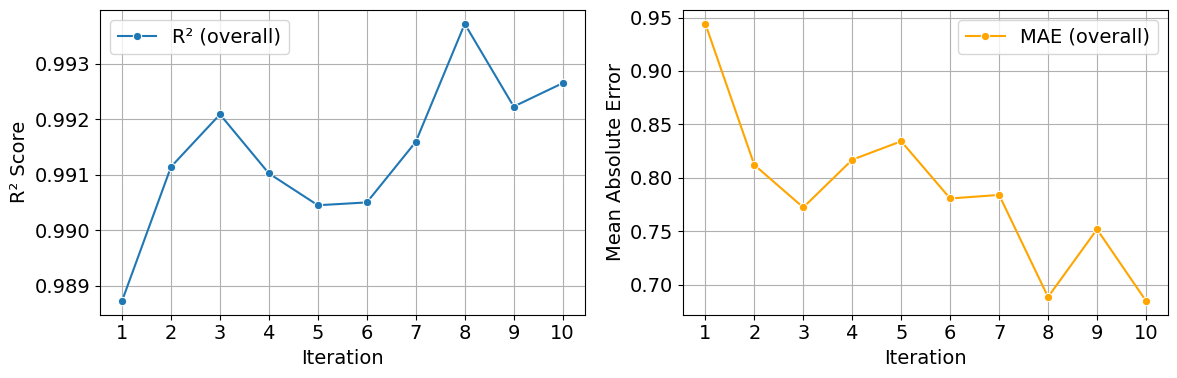

In [32]:
import seaborn as sns

iterations = list(range(1, len(r2_overall)+1))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- R² over iterations ---
sns.lineplot(x=iterations, y=r2_overall, marker='o', ax=axes[0], label='R² (overall)')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('R² Score')
axes[0].set_xticks(iterations)
axes[0].grid(True)
axes[0].legend()

# --- MAE over iterations ---
sns.lineplot(x=iterations, y=mae_overall, marker='o', color='orange', ax=axes[1], label='MAE (overall)')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Mean Absolute Error')
axes[1].set_xticks(iterations)
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [53]:
train_data.to_excel('Adaptive_train_data.xlsx')

In [54]:
train_data.columns

Index(['FEED1MASSFLOW', 'FEED1TEMP', 'PROD1MASSFLOW', 'PROD1TEMP', 'E1FOULING',
       'E2FOULING', 'PROD1E1IN', 'PROD1OUT', 'FEED1E1OUT', 'FEED1OUT'],
      dtype='object')

In [55]:
train_data

,FEED1MASSFLOW,FEED1TEMP,PROD1MASSFLOW,PROD1TEMP,E1FOULING,E2FOULING,PROD1E1IN,PROD1OUT,FEED1E1OUT,FEED1OUT
0,20250.000000,33.312500,55300.000000,132.187500,0.001949,0.002271,128.665907,124.277713,45.250853,54.937189
1,19750.000000,18.812500,40500.000000,126.787500,0.002580,0.001667,120.206908,115.293797,28.806615,42.325294
2,11850.000000,21.312500,40900.000000,110.812500,0.002594,0.001277,105.174697,101.408894,34.238131,53.612107
3,22350.000000,11.687500,33900.000000,98.437500,0.002808,0.001264,90.996119,86.851856,17.981827,29.212383
4,16250.000000,21.687500,37900.000000,94.387500,0.002835,0.002298,90.829663,87.639409,29.079679,37.312847
...,...,...,...,...,...,...,...,...,...,...
5,19543.592489,28.764332,55877.842885,128.931316,0.002832,0.001103,122.704419,119.518511,37.724542,55.597865
6,11107.131428,27.501642,20251.329864,118.214295,0.001679,0.002673,112.171017,103.031295,44.097107,55.106173
7,16818.515393,34.205393,31014.104903,122.401710,0.001672,0.002130,117.112772,110.291113,46.749132,56.518425
8,16997.528322,13.646449,51702.172702,100.988017,0.000807,0.002122,98.035482,91.175784,34.707937,43.624779


In [33]:
# Save the model
save_model(model, x_cols=x_cols, y_cols=y_cols, 
           scaler=scaler, path = '../00_Modell_database/AdaptiveModel', filename='sklearnann.joblib')

Model saved to ../00_Modell_database/AdaptiveModel\sklearnann.joblib


# comparisson

## Adaptive

In [44]:
df_test2 = pd.read_excel('../01_DataCollecting/Sim_result/Heat_exchanger_process_data_result_V4.xlsx', index_col=0)
df_test2.reset_index(drop=True, inplace=True)

In [45]:
scaled_test_df = scaler.x_scaler.transform(df_test2[x_cols])
pred_valid_adaptive = model.predict(scaled_test_df)
pred_valid_adaptive = scaler.y_scaler.inverse_transform(pred_valid_adaptive)
pred_valid_adaptive_df = pd.DataFrame(pred_valid_adaptive, columns=y_cols)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


## LHS model

In [46]:
df_raw = pd.read_csv(f"../01_DataCollecting/Sim_result/Surrogate_dataset_LHS_200.csv", index_col=0, encoding='ISO-8859-1')
df_raw.reset_index(drop=True, inplace=True)

In [47]:
scaler_lhs = DS()
scaled_df_lhs = scaler_lhs.fit_transform(df_raw, x_cols, y_cols)

X_train_lhs, X_test_lhs, y_train_lhs, y_test_lhs = train_test_split(scaled_df_lhs[x_cols], scaled_df_lhs[y_cols], train_size=0.7, random_state=42)

lhs_model = MLPRegressor(hidden_layer_sizes = (50,), activation = 'relu', random_state=42, max_iter=300, learning_rate = 'adaptive')
lhs_model.fit(X_train_lhs, y_train_lhs)

df_scaled_test_lhs = scaler_lhs.x_scaler.transform(df_test2[x_cols])

pred_valid_lhs = lhs_model.predict(df_scaled_test_lhs)
pred_valid_lhs = scaler_lhs.y_scaler.inverse_transform(pred_valid_lhs)

pred_valid_lhs_df = pd.DataFrame(pred_valid_lhs, columns=y_cols)

c:\Users\pales\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


In [48]:
print(f"LHS (200) R2:{r2_score(df_test2[y_cols], pred_valid_lhs_df[y_cols]):.2f}, MAE:{mean_absolute_error(df_test2[y_cols], pred_valid_lhs_df[y_cols]):.2f}")
print(f"Active learning (90) R2:{r2_score(df_test2[y_cols], pred_valid_adaptive_df[y_cols]):.2f}, MAE:{mean_absolute_error(df_test2[y_cols], pred_valid_adaptive_df[y_cols]):.2f}")

LHS (200) R2:0.88, MAE:1.65
Active learning (90) R2:0.87, MAE:1.77


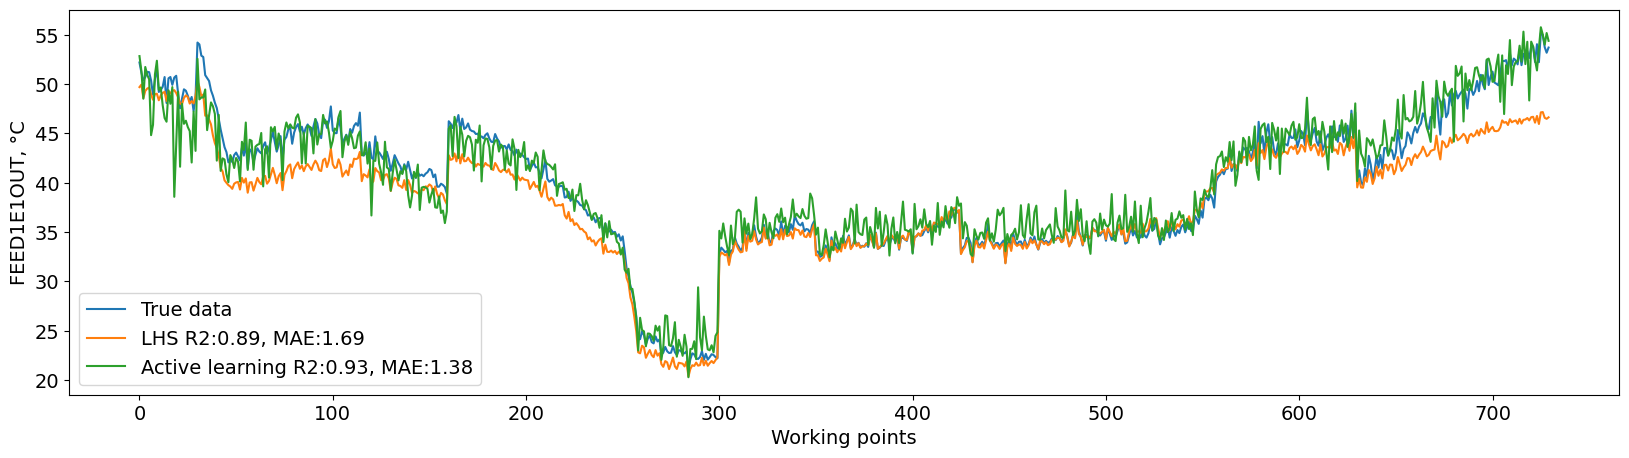

In [49]:
plt.figure(figsize=(20,5))
col = 'FEED1E1OUT'



plt.plot(df_test2[col], label = 'True data')
plt.plot(pred_valid_lhs_df[col], label = f'LHS R2:{r2_score(df_test2[col], pred_valid_lhs_df[col]):.2f}, MAE:{mean_absolute_error(df_test2[col], pred_valid_lhs_df[col]):.2f}')
plt.plot(pred_valid_adaptive_df[col], label = f'Active learning R2:{r2_score(df_test2[col], pred_valid_adaptive_df[col]):.2f}, MAE:{mean_absolute_error(df_test2[col], pred_valid_adaptive_df[col]):.2f}')
plt.legend()
plt.ylabel(f"{col}, °C")
plt.xlabel('Working points')
plt.show()

In [21]:
def generate_candidate_points(model, scaler, x_cols, n_total=3000, n_select=50, mc_iterations=50):
    from scipy.stats import qmc

    # Step 1: Sample candidate space
    bounds = {
        'FEED1MASSFLOW': (100, 300),
        'FEED1TEMP': (50, 200),
        'PROD1MASSFLOW': (80, 250),
        'PROD1TEMP': (50, 200),
        'E1FOULING': (0.0, 1.0),
        'E2FOULING': (0.0, 1.0)
    }

    variables = x_cols
    lower = np.array([bounds[v][0] for v in variables])
    upper = np.array([bounds[v][1] for v in variables])

    sampler = qmc.LatinHypercube(d=len(variables), seed=42)
    sample = sampler.random(n=n_total)
    candidate_points = qmc.scale(sample, lower, upper)
    df_candidates = pd.DataFrame(candidate_points, columns=variables)

    # Step 2: Scale and predict with BNN
    scaled_candidates = scaler.x_scaler.transform(df_candidates[variables])
    X_tensor = tf.convert_to_tensor(scaled_candidates, dtype=tf.float32)
    mean, std = predict_with_uncertainty(model, X_tensor, mc_iterations)

    # Step 3: Sample from high-uncertainty regions
    uncertainty_score = np.mean(std, axis=1)
    prob = uncertainty_score / np.sum(uncertainty_score)
    #selected_indices = np.argsort(-uncertainty_score)[:n_select]
    selected_indices = np.random.choice(len(df_candidates), size=n_select, replace=False, p=prob)

    return df_candidates.iloc[selected_indices].reset_index(drop=True)


In [20]:
generate_candidate_points(model, scaler, x_cols, n_total=3000, n_select=10, mc_iterations=50)

,FEED1MASSFLOW,FEED1TEMP,PROD1MASSFLOW,PROD1TEMP,E1FOULING,E2FOULING
0,218.478052,184.820295,188.786125,155.512716,0.594639,0.296742
1,277.613871,111.646127,211.216919,127.946599,0.767362,0.721752
2,107.777478,168.286394,192.928109,188.693023,0.642430,0.509926
3,260.407281,116.355328,249.403931,136.384204,0.659743,0.803779
4,100.244430,92.333466,180.802791,78.440564,0.747050,0.646185
5,123.337464,129.966660,122.391138,181.787158,0.790381,0.649546
6,250.309212,127.195618,173.436646,183.351905,0.977364,0.247433
7,184.726699,178.219687,111.842907,113.187935,0.282980,0.199484
8,144.691217,125.522557,101.816415,196.300283,0.743395,0.811171
9,204.434164,178.408936,97.473547,98.104047,0.294848,0.290536


In [14]:
from scipy.stats import qmc

def generate_candidate_points(n_points=20):
    bounds = {
        'FEED1MASSFLOW': (100, 300),
        'FEED1TEMP': (50, 200),
        'PROD1MASSFLOW': (80, 250),
        'PROD1TEMP': (50, 200),
        'E1FOULING': (0.0, 1.0),
        'E2FOULING': (0.0, 1.0)
    }

    variables = list(bounds.keys())
    lower = np.array([bounds[v][0] for v in variables])
    upper = np.array([bounds[v][1] for v in variables])

    sampler = qmc.LatinHypercube(d=len(variables), seed=42)
    sample = sampler.random(n=n_points)
    scaled_sample = qmc.scale(sample, lower, upper)

    return pd.DataFrame(scaled_sample, columns=variables)

In [15]:
generate_candidate_points()

,FEED1MASSFLOW,FEED1TEMP,PROD1MASSFLOW,PROD1TEMP,E1FOULING,E2FOULING
0,292.260440,121.708412,106.701918,187.269740,0.045291,0.951219
1,222.388603,74.104518,240.411034,69.122105,0.631460,0.753662
2,283.561349,148.829288,118.730979,168.295710,0.772271,0.596809
3,161.723688,90.262517,218.056254,122.341055,0.501465,0.405344
4,152.216165,101.040210,186.532871,199.671472,0.942286,0.715848
5,242.552378,65.243677,204.730484,54.721552,0.176522,0.390526
6,148.700785,136.432213,154.571271,134.976395,0.978142,0.058366
7,132.997349,167.657250,140.925792,148.964267,0.430626,0.935584
8,173.175045,108.951856,171.800780,79.944783,0.210654,0.166757
9,112.948346,59.144532,212.099216,158.234441,0.593010,0.694273


In [ ]:
# --- Active Learning Loop ---
for i in range(n_iterations):
    print(f"\n--- Iteration {i+1} ---")

    if len(X_pool) < points_per_iter:
        print(f"Stopping: not enough points left in pool ({len(X_pool)} remaining)")
        break

    # Train BNN
    model = build_bnn_model(input_dim, output_dim)
    model.fit(X_train, Y_train, epochs=200, batch_size=16, verbose=0)

    # Predict with uncertainty on training data
    X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
    train_mean, train_std = predict_with_uncertainty(model, X_train_tensor, mc_iterations)

    train_mean_inv = scaler.y_scaler.inverse_transform(train_mean)
    train_std_inv = train_std * scaler.y_scaler.scale_  # undo standardization on std
    Y_train_inv = scaler.y_scaler.inverse_transform(Y_train)

    # --- Plot training predictions and uncertainty with original indices ---
    x_axis = train_indices
    plt.figure(figsize=(12, 6))
    plt.errorbar(x_axis, train_mean_inv[:, target_index],
                 yerr=train_std_inv[:, target_index],
                 fmt='o', alpha=0.6, label='Prediction ± Uncertainty')

    plt.scatter(x_axis, Y_train_inv[:, target_index],
                color='black', s=20, alpha=0.7, label='True')

    if i > 0:
        # Last selected indices were appended to end of train_indices
        selected_indices = train_indices[-points_per_iter:]
        plt.scatter(selected_indices,
                    Y_train_inv[-points_per_iter:, target_index],
                    facecolors='none', edgecolors='red',
                    s=120, linewidths=2, label='Selected Last Iteration')

    plt.title(f'Model Performance on Training Data ({target_to_plot}) - Iteration {i+1}')
    plt.xlabel('Original index in df_total')
    plt.ylabel(target_to_plot)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Convert pool to tensors and predict
    X_pool_tensor = tf.convert_to_tensor(X_pool.values, dtype=tf.float32)
    pool_mean, pool_std = predict_with_uncertainty(model, X_pool_tensor, mc_iterations)

    # Acquisition: mean predictive std across outputs
    uncertainty_score = np.mean(pool_std, axis=1)
    top_k = min(points_per_iter, len(X_pool))

    # Get top_k POSITIONS (not labels!)
    top_k_pos = np.argsort(-uncertainty_score)[:top_k]

    # Get the actual DataFrame rows by position
    X_selected = X_pool.iloc[top_k_pos]
    Y_selected = Y_pool.iloc[top_k_pos]
    selected_indices = pool_indices[top_k_pos]

    # Add selected to training set
    X_train = np.vstack([X_train, X_selected])
    Y_train = np.vstack([Y_train, Y_selected])
    train_indices = np.concatenate([train_indices, selected_indices])

    # Remove selected from pool
    X_pool = X_pool.drop(X_selected.index)
    Y_pool = Y_pool.drop(Y_selected.index)
    pool_indices = np.delete(pool_indices, top_k_pos)


In [ ]:
https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/DL2/Bayesian_Neural_Networks/dl2_bnn_tut1_students_with_answers.html

In [ ]:
# init driver
simd = SM.simulation_driver(hy_filename, cols_mapping, x_cols, y_cols)
simd.load_model()